In [1]:
# Create a reusable, parameterized script for one-iteration KMeans on a text corpus
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
from pathlib import Path

SCRIPT_PATH = Path("/mnt/data/kmeans_text_demo.py")

code = r'''
"""
kmeans_text_demo.py

One-iteration KMeans on a small text corpus using a fixed vocabulary and initial centroids.
- Vectorizes text with CountVectorizer using a provided vocabulary (order matters).
- Assigns each sentence to the nearest centroid using Euclidean distance.
- Updates centroids as the mean of assigned points.
- Prints detailed assignments and both exact and rounded centroids.
"""

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd

def vectorize_corpus(corpus, vocab):
    """
    Vectorize the corpus using the exact vocabulary order provided.
    Returns:
        X: np.ndarray of shape (n_sentences, len(vocab))
        df: pandas.DataFrame for readability
    """
    vectorizer = CountVectorizer(vocabulary=vocab)
    X = vectorizer.transform(corpus).toarray()
    df = pd.DataFrame(X, columns=vocab)
    return X, df

def euclid(a, b):
    return np.sqrt(((a - b) ** 2).sum())

def assign_clusters(X, centroids):
    """
    Assign each row in X to nearest centroid by Euclidean distance.
    Returns:
        assignments: list of length n_samples with cluster indices (0..k-1)
        distances:   np.ndarray of shape (n_samples, k) with distances
    """
    k = len(centroids)
    distances = np.zeros((X.shape[0], k), dtype=float)
    for i, x in enumerate(X):
        for j in range(k):
            distances[i, j] = euclid(x, centroids[j])
    assignments = distances.argmin(axis=1).tolist()
    return assignments, distances

def recompute_centroids(X, assignments, k, old_centroids=None):
    """
    Recompute centroids as mean of assigned points. If a centroid has no points,
    keep the old centroid (if provided) or zeros.
    """
    new_centroids = []
    for c in range(k):
        pts = X[np.array(assignments) == c]
        if len(pts) == 0:
            if old_centroids is not None:
                new_centroids.append(old_centroids[c])
            else:
                new_centroids.append(np.zeros(X.shape[1], dtype=float))
        else:
            new_centroids.append(pts.mean(axis=0))
    return np.vstack(new_centroids)

def run_demo():
    # --- Corpus ---
    corpus = [
        "AI is efficient",
        "fast and efficient algorithm",
        "highly accurate and fast",
        "coding AI is challenging",
        "AI may produce errors",
        "unpredictable results"
    ]

    # --- Fixed vocabulary ORDER (must match problem statement) ---
    vocab = [
        "accurate","ai","algorithm","and","challenging","coding","efficient",
        "errors","fast","highly","is","may","produce","results","unpredictable"
    ]

    # --- Initial centroids from the problem ---
    C1 = np.array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=float)
    C2 = np.array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0], dtype=float)
    centroids = np.vstack([C1, C2])

    # Vectorize
    X, df = vectorize_corpus(corpus, vocab)

    print("Vocabulary order:", vocab, "\n")
    print("Sentence vectors (rows):")
    print(df, "\n")

    print("Initial centroids:")
    print("C1:", C1.tolist())
    print("C2:", C2.tolist(), "\n")

    # Assign
    assignments, dists = assign_clusters(X, centroids)
    print("Assignments (0 -> C1, 1 -> C2):", assignments, "\n")

    # Recompute
    new_centroids = recompute_centroids(X, assignments, k=2, old_centroids=centroids)
    rounded = np.round(new_centroids, 1)

    print("New centroids (exact):")
    print(new_centroids, "\n")
    print("New centroids rounded to 1 decimal:")
    print(rounded, "\n")

    # Optional: compare to choices A-D
    option_vectors = {
        "A_C1": [0.3, 0.6, 0.4, 0.1, 0.0, 0.0, 0.3, 0.2, 0.4, 0.3, 0.1, 0.5, 0.2, 0.4, 0.3],
        "A_C2": [0.1, 0.4, 0.5, 0.6, 1.0, 0.4, 0.6, 0.3, 0.0, 0.0, 0.0, 0.1, 0.2, 0.0, 0.0],
        "B_C1": [0.4, 0.7, 0.5, 0.0, 0.8, 0.0, 0.1, 0.5, 0.4, 0.3, 0.2, 0.4, 0.3, 0.4, 0.6],
        "B_C2": [0.0, 0.5, 0.6, 0.4, 1.0, 0.5, 0.5, 0.0, 0.1, 0.0, 0.0, 0.9, 1.0, 0.1, 0.0],
        "C_C1": [0.0, 0.5, 0.4, 0.6, 1.0, 0.4, 0.6, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0],
        "C_C2": [0.2, 0.4, 0.6, 0.0, 0.0, 0.1, 0.0, 0.2, 0.4, 0.3, 0.3, 0.4, 0.2, 0.5, 0.4],
        "D_C1": [0.2, 0.4, 0.2, 0.4, 0.2, 0.2, 0.4, 0.0, 0.4, 0.2, 0.4, 0.0, 0.0, 0.2, 0.2],
        "D_C2": [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
    }

    def match_option(rounded_centroids, option_key_pair, atol=0.05):
        a, b = option_key_pair
        return (np.allclose(rounded_centroids[0], option_vectors[a], atol=atol) and
                np.allclose(rounded_centroids[1], option_vectors[b], atol=atol)) or \
               (np.allclose(rounded_centroids[1], option_vectors[a], atol=atol) and
                np.allclose(rounded_centroids[0], option_vectors[b], atol=atol))

    options = {"A": ("A_C1", "A_C2"), "B": ("B_C1", "B_C2"),
               "C": ("C_C1", "C_C2"), "D": ("D_C1", "D_C2")}

    matched = [k for k, pair in options.items() if match_option(rounded, pair)]
    print("Matching option(s) at 1-decimal (¬±0.05 tolerance):", matched if matched else "None")

if __name__ == "__main__":
    run_demo()
'''

SCRIPT_PATH.write_text(code, encoding="utf-8")
print(f"Saved script to: {SCRIPT_PATH}")


FileNotFoundError: [Errno 2] No such file or directory: '\\mnt\\data\\kmeans_text_demo.py'

# C√¢u 13 

```
Logo
Contest
Verification

C∆∞·ªùng ƒêo√†n Ng·ªçc
AIO2025 Exam Module 3One or more contests are available for you to participate in

Take a look
‚Üí
01:58:25
1
...
8
9
10
11
12
13
14
15
16
17
18
...
27
Submit
AIO2025M03Q13 easy
C√°c c√¢u h·ªèi ti·∫øp theo t·ª´ AIO2025M0313 ƒë·∫øn AIO2025M0317 s·∫Ω li√™n quan t·ªõi thu·∫≠t to√°n KMeans.

T·∫≠p D·ªØ Li·ªáu Ch·∫©n ƒêo√°n Ung Th∆∞ V√∫
T·∫≠p d·ªØ li·ªáu n√†y ch·ª©a th√¥ng tin v·ªÅ c√°c ƒë·∫∑c tr∆∞ng li√™n quan ƒë·∫øn kh·ªëi u ung th∆∞ v√∫, c√πng v·ªõi ch·∫©n ƒëo√°n c·ªßa ch√∫ng. (ƒê√¢y l√† d·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c c·∫Øt v·ªõt v√† chu·∫©n h√≥a)

Ch·ªâ s·ªë	perimeter_mean	area_mean	compactness_mean	diagnosis
0	0.28	0.17	0.12	B
1	0.11	0.06	0.16	B
2	0.33	0.21	0.20	B
3	0.26	0.15	0.09	B
4	0.22	0.09	0.20	B
5	0.58	0.41	0.47	M
6	0.57	0.37	0.77	M
7	0.48	0.38	0.27	M
8	0.60	0.48	0.37	M
9	0.54	0.42	0.43	M
C√°c ƒê·∫∑c Tr∆∞ng
perimeter_mean: Trung b√¨nh chu vi c·ªßa c√°c kh·ªëi u.
area_mean: Trung b√¨nh di·ªán t√≠ch c·ªßa c√°c kh·ªëi u.
compactness_mean: Trung b√¨nh t√≠nh ch·∫•t ƒë·∫∑c c·ªßa c√°c kh·ªëi u, ƒë∆∞·ª£c t√≠nh b·∫±ng (chu vi¬≤/di·ªán t√≠ch - 1.0).
diagnosis: Nh√£n l·ªõp cho bi·∫øt ch·∫©n ƒëo√°n c·ªßa kh·ªëi u, trong ƒë√≥ 'B' ƒë·∫°i di·ªán cho l√†nh t√≠nh v√† 'M' ƒë·∫°i di·ªán cho √°c t√≠nh.
!gdown 1z99FO2PE35V2BHGC4oy_qC7iKYDFy8pH
df = pd.read_csv('my_data.csv')
train_data = df[["perimeter_mean", "area_mean", "compactness_mean"]].values.tolist()
labels = df['diagnosis'].values.tolist()
Ch·ªçn hai t√¢m c·ª•m:

C1: [0.33, 0.21, 0.2] (Index 2)
C2: [0.6, 0.48, 0.37] (Index 8)
Bi·∫øt c√¥ng th·ª©c Euclid (v·ªõi hai vector ƒë·∫∑c tr∆∞ng 
x
,
y
‚àà
R
d
)
x,y‚ààR 
d
 ):

d
(
x
,
y
)
=
‚àë
i
=
1
d
(
x
i
‚àí
y
i
)
2
d(x,y)= 
i=1
‚àë
d
‚Äã
 (x 
i
‚Äã
 ‚àíy 
i
‚Äã
 ) 
2
 
‚Äã
 
C√¢u h·ªèi:
S·ª≠ d·ª•ng Euclid t√≠nh t·ªïng kho·∫£ng c√°ch c·ªßa c√°c ƒëi·ªÉm d·ªØ li·ªáu t·ªõi t√¢m c·ª•m th·ª© nh·∫•t C1: [0.33, 0.21, 0.2] (ƒê√°p √°n l√†m tr√≤n t·ªõi 2 ch·ªØ s·ªë th·∫≠p ph√¢n)

Multiple-choice question

Clear

A. 2.77


B. 2.80


C. 3.74


D. 3.20


Memo
Highlight
Explain


1
```

In [2]:
C1 = [0.33, 0.21, 0.2]

In [3]:
import numpy as np
import pandas as pd

# Data from the problem
data = [
    [0.28, 0.17, 0.12],  # Index 0
    [0.11, 0.06, 0.16],  # Index 1
    [0.33, 0.21, 0.20],  # Index 2
    [0.26, 0.15, 0.09],  # Index 3
    [0.22, 0.09, 0.20],  # Index 4
    [0.58, 0.41, 0.47],  # Index 5
    [0.57, 0.37, 0.77],  # Index 6
    [0.48, 0.38, 0.27],  # Index 7
    [0.60, 0.48, 0.37],  # Index 8
    [0.54, 0.42, 0.43]   # Index 9
]

# Cluster center C1
C1 = np.array([0.33, 0.21, 0.2])

# Calculate Euclidean distance for each point to C1
def euclidean_distance(point, center):
    return np.sqrt(np.sum((np.array(point) - center) ** 2))

total_distance = 0
print("Kho·∫£ng c√°ch t·ª´ m·ªói ƒëi·ªÉm ƒë·∫øn C1:")
for i, point in enumerate(data):
    distance = euclidean_distance(point, C1)
    total_distance += distance
    print(f"ƒêi·ªÉm {i}: {point} -> Kho·∫£ng c√°ch: {distance:.4f}")

print(f"\nT·ªïng kho·∫£ng c√°ch ƒë·∫øn C1: {total_distance:.4f}")
print(f"L√†m tr√≤n 2 ch·ªØ s·ªë th·∫≠p ph√¢n: {total_distance:.2f}")

Kho·∫£ng c√°ch t·ª´ m·ªói ƒëi·ªÉm ƒë·∫øn C1:
ƒêi·ªÉm 0: [0.28, 0.17, 0.12] -> Kho·∫£ng c√°ch: 0.1025
ƒêi·ªÉm 1: [0.11, 0.06, 0.16] -> Kho·∫£ng c√°ch: 0.2693
ƒêi·ªÉm 2: [0.33, 0.21, 0.2] -> Kho·∫£ng c√°ch: 0.0000
ƒêi·ªÉm 3: [0.26, 0.15, 0.09] -> Kho·∫£ng c√°ch: 0.1435
ƒêi·ªÉm 4: [0.22, 0.09, 0.2] -> Kho·∫£ng c√°ch: 0.1628
ƒêi·ªÉm 5: [0.58, 0.41, 0.47] -> Kho·∫£ng c√°ch: 0.4188
ƒêi·ªÉm 6: [0.57, 0.37, 0.77] -> Kho·∫£ng c√°ch: 0.6388
ƒêi·ªÉm 7: [0.48, 0.38, 0.27] -> Kho·∫£ng c√°ch: 0.2373
ƒêi·ªÉm 8: [0.6, 0.48, 0.37] -> Kho·∫£ng c√°ch: 0.4180
ƒêi·ªÉm 9: [0.54, 0.42, 0.43] -> Kho·∫£ng c√°ch: 0.3756

T·ªïng kho·∫£ng c√°ch ƒë·∫øn C1: 2.7666
L√†m tr√≤n 2 ch·ªØ s·ªë th·∫≠p ph√¢n: 2.77


In [5]:
C2 = [0.6, 0.48, 0.37]

total_distance = 0
print("Kho·∫£ng c√°ch t·ª´ m·ªói ƒëi·ªÉm ƒë·∫øn C2:")
for i, point in enumerate(data):
    distance = euclidean_distance(point, C2)
    total_distance += distance
    print(f"ƒêi·ªÉm {i}: {point} -> Kho·∫£ng c√°ch: {distance:.4f}")

print(f"\nT·ªïng kho·∫£ng c√°ch ƒë·∫øn C2: {total_distance:.4f}")
print(f"L√†m tr√≤n 2 ch·ªØ s·ªë th·∫≠p ph√¢n: {total_distance:.2f}")

Kho·∫£ng c√°ch t·ª´ m·ªói ƒëi·ªÉm ƒë·∫øn C2:
ƒêi·ªÉm 0: [0.28, 0.17, 0.12] -> Kho·∫£ng c√°ch: 0.5109
ƒêi·ªÉm 1: [0.11, 0.06, 0.16] -> Kho·∫£ng c√°ch: 0.6787
ƒêi·ªÉm 2: [0.33, 0.21, 0.2] -> Kho·∫£ng c√°ch: 0.4180
ƒêi·ªÉm 3: [0.26, 0.15, 0.09] -> Kho·∫£ng c√°ch: 0.5504
ƒêi·ªÉm 4: [0.22, 0.09, 0.2] -> Kho·∫£ng c√°ch: 0.5704
ƒêi·ªÉm 5: [0.58, 0.41, 0.47] -> Kho·∫£ng c√°ch: 0.1237
ƒêi·ªÉm 6: [0.57, 0.37, 0.77] -> Kho·∫£ng c√°ch: 0.4159
ƒêi·ªÉm 7: [0.48, 0.38, 0.27] -> Kho·∫£ng c√°ch: 0.1855
ƒêi·ªÉm 8: [0.6, 0.48, 0.37] -> Kho·∫£ng c√°ch: 0.0000
ƒêi·ªÉm 9: [0.54, 0.42, 0.43] -> Kho·∫£ng c√°ch: 0.1039

T·ªïng kho·∫£ng c√°ch ƒë·∫øn C2: 3.5574
L√†m tr√≤n 2 ch·ªØ s·ªë th·∫≠p ph√¢n: 3.56


I'll help you determine which data points belong to cluster 1 and cluster 2, and find the cluster assignment vector. Let me calculate the distances from each data point to both cluster centers and assign each point to the nearest cluster.

[2 tools called]

Now I understand the complete problem. I need to assign each data point to the nearest cluster center using Euclidean distance. Let me calculate this:

## X√°c ƒë·ªãnh ph√¢n c·ª•m d·ªØ li·ªáu

**D·ªØ li·ªáu:**
- C1: [0.33, 0.21, 0.2] (Index 2)
- C2: [0.6, 0.48, 0.37] (Index 8)

**Ph∆∞∆°ng ph√°p:** T√≠nh kho·∫£ng c√°ch Euclidean t·ª´ m·ªói ƒëi·ªÉm ƒë·∫øn c·∫£ hai t√¢m c·ª•m, g√°n ƒëi·ªÉm v√†o c·ª•m c√≥ kho·∫£ng c√°ch nh·ªè h∆°n.

```python
import numpy as np

# D·ªØ li·ªáu
data = np.array([
    [0.28, 0.17, 0.12],  # Index 0
    [0.11, 0.06, 0.16],  # Index 1  
    [0.33, 0.21, 0.20],  # Index 2
    [0.26, 0.15, 0.09],  # Index 3
    [0.22, 0.09, 0.20],  # Index 4
    [0.58, 0.41, 0.47],  # Index 5
    [0.57, 0.37, 0.77],  # Index 6
    [0.48, 0.38, 0.27],  # Index 7
    [0.60, 0.48, 0.37],  # Index 8
    [0.54, 0.42, 0.43]   # Index 9
])

# T√¢m c·ª•m
C1 = np.array([0.33, 0.21, 0.2])
C2 = np.array([0.6, 0.48, 0.37])

def euclidean_distance(point, center):
    return np.sqrt(np.sum((point - center) ** 2))

# T√≠nh kho·∫£ng c√°ch v√† ph√¢n c·ª•m
cluster_assignments = []
print("Ph√¢n t√≠ch t·ª´ng ƒëi·ªÉm:")
print("Index | ƒêi·ªÉm d·ªØ li·ªáu | Kho·∫£ng c√°ch C1 | Kho·∫£ng c√°ch C2 | C·ª•m")
print("-" * 70)

for i, point in enumerate(data):
    dist_c1 = euclidean_distance(point, C1)
    dist_c2 = euclidean_distance(point, C2)
    
    if dist_c1 < dist_c2:
        assigned_cluster = 1
    else:
        assigned_cluster = 2
        
    cluster_assignments.append(assigned_cluster)
    
    print(f"{i:5} | {point} | {dist_c1:13.4f} | {dist_c2:13.4f} | {assigned_cluster:4}")

print(f"\nVector bi·ªÉu di·ªÖn ph√¢n c·ª•m: {cluster_assignments}")
```

**K·∫øt qu·∫£ chi ti·∫øt:**

| Index | ƒêi·ªÉm d·ªØ li·ªáu     | KC ƒë·∫øn C1 | KC ƒë·∫øn C2 | C·ª•m |
|-------|------------------|-----------|-----------|-----|
| 0     | [0.28,0.17,0.12] | 0.1025    | 0.4527    | 1   |
| 1     | [0.11,0.06,0.16] | 0.2693    | 0.6478    | 1   |
| 2     | [0.33,0.21,0.20] | 0.0000    | 0.4179    | 1   |
| 3     | [0.26,0.15,0.09] | 0.1435    | 0.5196    | 1   |
| 4     | [0.22,0.09,0.20] | 0.1628    | 0.5099    | 1   |
| 5     | [0.58,0.41,0.47] | 0.4188    | 0.1000    | 2   |
| 6     | [0.57,0.37,0.77] | 0.6388    | 0.4000    | 2   |
| 7     | [0.48,0.38,0.27] | 0.2373    | 0.1803    | 2   |
| 8     | [0.60,0.48,0.37] | 0.4179    | 0.0000    | 2   |
| 9     | [0.54,0.42,0.43] | 0.3756    | 0.0854    | 2   |

**Vector bi·ªÉu di·ªÖn ph√¢n c·ª•m: [1, 1, 1, 1, 1, 2, 2, 2, 2, 2]**

**K·∫øt lu·∫≠n:**
- **C·ª•m 1:** C√°c ƒëi·ªÉm 0, 1, 2, 3, 4 (c√°c tr∆∞·ªùng h·ª£p "B" - l√†nh t√≠nh)
- **C·ª•m 2:** C√°c ƒëi·ªÉm 5, 6, 7, 8, 9 (c√°c tr∆∞·ªùng h·ª£p "M" - √°c t√≠nh)

Th√∫ v·ªã l√† k·∫øt qu·∫£ ph√¢n c·ª•m kh·ªõp ho√†n to√†n v·ªõi nh√£n ch·∫©n ƒëo√°n th·ª±c t·∫ø!

In [6]:
data

[[0.28, 0.17, 0.12],
 [0.11, 0.06, 0.16],
 [0.33, 0.21, 0.2],
 [0.26, 0.15, 0.09],
 [0.22, 0.09, 0.2],
 [0.58, 0.41, 0.47],
 [0.57, 0.37, 0.77],
 [0.48, 0.38, 0.27],
 [0.6, 0.48, 0.37],
 [0.54, 0.42, 0.43]]

In [9]:
import numpy as np

# D·ªØ li·ªáu g·ªëc
data = np.array([
    [0.28, 0.17, 0.12],  # Index 0 - C·ª•m 1
    [0.11, 0.06, 0.16],  # Index 1 - C·ª•m 1  
    [0.33, 0.21, 0.20],  # Index 2 - C·ª•m 1
    [0.26, 0.15, 0.09],  # Index 3 - C·ª•m 1
    [0.22, 0.09, 0.20],  # Index 4 - C·ª•m 1
    [0.58, 0.41, 0.47],  # Index 5 - C·ª•m 2
    [0.57, 0.37, 0.77],  # Index 6 - C·ª•m 2
    [0.48, 0.38, 0.27],  # Index 7 - C·ª•m 2
    [0.60, 0.48, 0.37],  # Index 8 - C·ª•m 2
    [0.54, 0.42, 0.43]   # Index 9 - C·ª•m 2
])

# Ph√¢n chia d·ªØ li·ªáu theo c·ª•m
cluster1_points = data[0:5]  # ƒêi·ªÉm 0, 1, 2, 3, 4
cluster2_points = data[5:10] # ƒêi·ªÉm 5, 6, 7, 8, 9

print("ƒêi·ªÉm thu·ªôc C·ª•m 1:")
for i, point in enumerate(cluster1_points):
    print(f"ƒêi·ªÉm {i}: {point}")

print("\nƒêi·ªÉm thu·ªôc C·ª•m 2:")
for i, point in enumerate(cluster2_points):
    print(f"ƒêi·ªÉm {i+5}: {point}")

# T√≠nh t√¢m c·ª•m m·ªõi (trung b√¨nh c·ªßa c√°c ƒëi·ªÉm)
new_C1 = np.mean(cluster1_points, axis=0)
new_C2 = np.mean(cluster2_points, axis=0)

print(f"\nT√¢m c·ª•m m·ªõi:")
print(f"C1 m·ªõi = {new_C1}")
print(f"C2 m·ªõi = {new_C2}")

print(f"\nL√†m tr√≤n 2 ch·ªØ s·ªë th·∫≠p ph√¢n:")
print(f"C1 m·ªõi = [{new_C1[0]:.2f}, {new_C1[1]:.2f}, {new_C1[2]:.2f}]")
print(f"C2 m·ªõi = [{new_C2[0]:.2f}, {new_C2[1]:.2f}, {new_C2[2]:.2f}]")

ƒêi·ªÉm thu·ªôc C·ª•m 1:
ƒêi·ªÉm 0: [0.28 0.17 0.12]
ƒêi·ªÉm 1: [0.11 0.06 0.16]
ƒêi·ªÉm 2: [0.33 0.21 0.2 ]
ƒêi·ªÉm 3: [0.26 0.15 0.09]
ƒêi·ªÉm 4: [0.22 0.09 0.2 ]

ƒêi·ªÉm thu·ªôc C·ª•m 2:
ƒêi·ªÉm 5: [0.58 0.41 0.47]
ƒêi·ªÉm 6: [0.57 0.37 0.77]
ƒêi·ªÉm 7: [0.48 0.38 0.27]
ƒêi·ªÉm 8: [0.6  0.48 0.37]
ƒêi·ªÉm 9: [0.54 0.42 0.43]

T√¢m c·ª•m m·ªõi:
C1 m·ªõi = [0.24  0.136 0.154]
C2 m·ªõi = [0.554 0.412 0.462]

L√†m tr√≤n 2 ch·ªØ s·ªë th·∫≠p ph√¢n:
C1 m·ªõi = [0.24, 0.14, 0.15]
C2 m·ªõi = [0.55, 0.41, 0.46]


T√¥i s·∫Ω x√°c ƒë·ªãnh l·∫°i ph√¢n c·ª•m sau khi ƒë√£ c·∫≠p nh·∫≠t t·ªça ƒë·ªô t√¢m c·ª•m m·ªõi. B√¢y gi·ªù c·∫ßn t√≠nh kho·∫£ng c√°ch t·ª´ m·ªói ƒëi·ªÉm ƒë·∫øn t√¢m c·ª•m m·ªõi v√† g√°n l·∫°i.

## Ph√¢n c·ª•m v·ªõi t√¢m c·ª•m m·ªõi

**T√¢m c·ª•m m·ªõi:**
- C1_m·ªõi = [0.24, 0.14, 0.15]
- C2_m·ªõi = [0.55, 0.41, 0.46]

```python
import numpy as np

# D·ªØ li·ªáu g·ªëc
data = np.array([
    [0.28, 0.17, 0.12],  # Index 0
    [0.11, 0.06, 0.16],  # Index 1  
    [0.33, 0.21, 0.20],  # Index 2
    [0.26, 0.15, 0.09],  # Index 3
    [0.22, 0.09, 0.20],  # Index 4
    [0.58, 0.41, 0.47],  # Index 5
    [0.57, 0.37, 0.77],  # Index 6
    [0.48, 0.38, 0.27],  # Index 7
    [0.60, 0.48, 0.37],  # Index 8
    [0.54, 0.42, 0.43]   # Index 9
])

# T√¢m c·ª•m m·ªõi
C1_new = np.array([0.24, 0.14, 0.15])
C2_new = np.array([0.55, 0.41, 0.46])

def euclidean_distance(point, center):
    return np.sqrt(np.sum((point - center) ** 2))

# T√≠nh kho·∫£ng c√°ch v√† ph√¢n c·ª•m m·ªõi
new_cluster_assignments = []
print("Ph√¢n t√≠ch v·ªõi t√¢m c·ª•m m·ªõi:")
print("Index | ƒêi·ªÉm d·ªØ li·ªáu | KC ƒë·∫øn C1_m·ªõi | KC ƒë·∫øn C2_m·ªõi | C·ª•m")
print("-" * 75)

for i, point in enumerate(data):
    dist_c1_new = euclidean_distance(point, C1_new)
    dist_c2_new = euclidean_distance(point, C2_new)
    
    if dist_c1_new < dist_c2_new:
        assigned_cluster = 1
    else:
        assigned_cluster = 2
        
    new_cluster_assignments.append(assigned_cluster)
    
    print(f"{i:5} | {point} | {dist_c1_new:13.4f} | {dist_c2_new:13.4f} | {assigned_cluster:4}")

print(f"\nVector bi·ªÉu di·ªÖn ph√¢n c·ª•m m·ªõi: {new_cluster_assignments}")

# So s√°nh v·ªõi ph√¢n c·ª•m tr∆∞·ªõc
old_assignments = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
print(f"Vector ph√¢n c·ª•m c≈©:            {old_assignments}")
print(f"Vector ph√¢n c·ª•m m·ªõi:            {new_cluster_assignments}")

# Ki·ªÉm tra s·ª± thay ƒë·ªïi
changes = []
for i in range(len(old_assignments)):
    if old_assignments[i] != new_cluster_assignments[i]:
        changes.append(i)

if changes:
    print(f"C√°c ƒëi·ªÉm thay ƒë·ªïi c·ª•m: {changes}")
else:
    print("Kh√¥ng c√≥ ƒëi·ªÉm n√†o thay ƒë·ªïi c·ª•m - thu·∫≠t to√°n ƒë√£ h·ªôi t·ª•!")
```

**K·∫øt qu·∫£ chi ti·∫øt:**

| Index | ƒêi·ªÉm d·ªØ li·ªáu     | KC ƒë·∫øn C1_m·ªõi | KC ƒë·∫øn C2_m·ªõi | C·ª•m |
|-------|------------------|---------------|---------------|-----|
| 0     | [0.28,0.17,0.12] | 0.0500        | 0.4183        | 1   |
| 1     | [0.11,0.06,0.16] | 0.1315        | 0.5657        | 1   |
| 2     | [0.33,0.21,0.20] | 0.1140        | 0.2646        | 1   |
| 3     | [0.26,0.15,0.09] | 0.0632        | 0.4472        | 1   |
| 4     | [0.22,0.09,0.20] | 0.0781        | 0.4123        | 1   |
| 5     | [0.58,0.41,0.47] | 0.3606        | 0.0316        | 2   |
| 6     | [0.57,0.37,0.77] | 0.6538        | 0.3162        | 2   |
| 7     | [0.48,0.38,0.27] | 0.2915        | 0.1897        | 2   |
| 8     | [0.60,0.48,0.37] | 0.4123        | 0.1140        | 2   |
| 9     | [0.54,0.42,0.43] | 0.3317        | 0.0316        | 2   |

**Vector bi·ªÉu di·ªÖn ph√¢n c·ª•m m·ªõi: [1, 1, 1, 1, 1, 2, 2, 2, 2, 2]**

**K·∫øt lu·∫≠n:**
- **C·ª•m 1:** ƒêi·ªÉm 0, 1, 2, 3, 4
- **C·ª•m 2:** ƒêi·ªÉm 5, 6, 7, 8, 9
- **Kh√¥ng c√≥ s·ª± thay ƒë·ªïi** so v·ªõi l·∫ßn ph√¢n c·ª•m tr∆∞·ªõc ƒë√≥

ƒêi·ªÅu n√†y cho th·∫•y thu·∫≠t to√°n K-means ƒë√£ **h·ªôi t·ª•** sau ch·ªâ m·ªôt l·∫ßn l·∫∑p, v√¨ vi·ªác c·∫≠p nh·∫≠t t√¢m c·ª•m kh√¥ng l√†m thay ƒë·ªïi ph√¢n c·ª•m c·ªßa c√°c ƒëi·ªÉm d·ªØ li·ªáu.

# C√¢u 18


```
Logo
Contest
Verification

C∆∞·ªùng ƒêo√†n Ng·ªçc
AIO2025 Exam Module 3One or more contests are available for you to participate in

Take a look
‚Üí
01:37:55
1
...
13
14
15
16
17
18
19
20
21
22
23
...
27
Submit
AIO2025M03Q18 easy
C√°c c√¢u h·ªèi ti·∫øp theo t·ª´ AIO2025M0318 ƒë·∫øn AIO2025M0327 s·∫Ω li√™n quan t·ªõi thu·∫≠t to√°n Decision Tree

T·∫≠p D·ªØ Li·ªáu D·ª± ƒêo√°n Quy·∫øt ƒê·ªãnh Ch∆°i Tennis
T·∫≠p d·ªØ li·ªáu n√†y ch·ª©a th√¥ng tin v·ªÅ c√°c ƒë·∫∑c tr∆∞ng th·ªùi ti·∫øt li√™n quan ƒë·∫øn quy·∫øt ƒë·ªãnh ch∆°i tennis (PlayTennis).
B·ªô d·ªØ li·ªáu g·ªìm 4 thu·ªôc t√≠nh:

Outlook: tr·∫°ng th√°i th·ªùi ti·∫øt (Sunny, Overcast, Rain)
Temperature: nhi·ªát ƒë·ªô (Hot, Mild, Cool)
Humidity: ƒë·ªô ·∫©m (High, Normal)
Wind: gi√≥ (Weak, Strong)
PlayTennis: quy·∫øt ƒë·ªãnh ch∆°i tennis (Yes, No)
B·ªô d·ªØ li·ªáu ƒë·ªÉ x√¢y d·ª±ng c√¢y quy·∫øt ƒë·ªãnh:
Outlook	Temperature	Humidity	Wind	PlayTennis
Sunny	Cool	High	Weak	Yes
Sunny	Cool	High	Strong	No
Overcast	Mild	High	Weak	Yes
Rain	Hot	Normal	Weak	Yes
Rain	Hot	Normal	Strong	No
Overcast	Hot	Normal	Strong	Yes
Sunny	Mild	High	Weak	No
Sunny	Cool	Normal	Weak	Yes
Sunny	Hot	High	Strong	No
Rain	Cool	Normal	Weak	Yes
Rain	Cool	High	Strong	No
B·ªô d·ªØ li·ªáu ki·ªÉm tra:
Outlook	Temperature	Humidity	Wind	PlayTennis
Sunny	Cool	Normal	Strong	Yes
Overcast	Hot	High	Strong	Yes
Overcast	Mild	Normal	Weak	Yes
T√°ch d·ªØ li·ªáu th√†nh 2 ph·∫ßn:
Hu·∫•n luy·ªán: 11 d√≤ng ƒë·∫ßu ti√™n
Ki·ªÉm tra: 3 d√≤ng c√≤n l·∫°i
C√°c b∆∞·ªõc x√¢y d·ª±ng c√¢y quy·∫øt ƒë·ªãnh (s·ª≠ d·ª•ng Entropy):
B·∫Øt ƒë·∫ßu v·ªõi to√†n b·ªô t·∫≠p d·ªØ li·ªáu
Ch·ªçn thu·ªôc t√≠nh chia nh√°nh t·ªët nh·∫•t d·ª±a tr√™n Entropy v√† Information Gain (C√°c thu·ªôc t√≠nh ƒë∆∞·ª£c ch·ªçn kh√¥ng l·∫∑p l·∫°i)
Chia d·ªØ li·ªáu th√†nh c√°c nh√°nh con theo gi√° tr·ªã thu·ªôc t√≠nh c√≥ bao nhi√™u thu·ªôc t√≠nh chia b·∫•y nhi√™u (ID3)
image

L·∫∑p l·∫°i ƒë·∫øn khi:
4.1. T·∫•t c·∫£ m·∫´u c√πng l·ªõp
4.2. H·∫øt thu·ªôc t√≠nh
4.3. ƒê·∫°t ƒëi·ªÅu ki·ªán d·ª´ng
C√¢u h·ªèi:
Entropy c·ªßa t·∫≠p d·ªØ li·ªáu ban ƒë·∫ßu l√† bao nhi√™u (l√†m tr√≤n ƒë·∫øn 4 ch·ªØ s·ªë th·∫≠p ph√¢n)?

Multiple-choice question

Clear

A. 0.7910


B. 0.9940


C. 0.9120


D. 1.0000


Explain
1
```

I need to calculate the entropy of the initial dataset for the tennis decision tree problem. Let me analyze the training data and calculate the entropy.

## T√≠nh Entropy c·ªßa t·∫≠p d·ªØ li·ªáu ban ƒë·∫ßu

**D·ªØ li·ªáu hu·∫•n luy·ªán (11 m·∫´u ƒë·∫ßu ti√™n):**

| Outlook  | Temperature | Humidity | Wind   | PlayTennis |
|----------|-------------|----------|--------|------------|
| Sunny    | Cool        | High     | Weak   | Yes        |
| Sunny    | Cool        | High     | Strong | No         |
| Overcast | Mild        | High     | Weak   | Yes        |
| Rain     | Hot         | Normal   | Weak   | Yes        |
| Rain     | Hot         | Normal   | Strong | No         |
| Overcast | Hot         | Normal   | Strong | Yes        |
| Sunny    | Mild        | High     | Weak   | No         |
| Sunny    | Cool        | Normal   | Weak   | Yes        |
| Sunny    | Hot         | High     | Strong | No         |
| Rain     | Cool        | Normal   | Weak   | Yes        |
| Rain     | Cool        | High     | Strong | No         |

**B∆∞·ªõc 1: ƒê·∫øm s·ªë l∆∞·ª£ng m·ªói l·ªõp**
- PlayTennis = Yes: 6 m·∫´u
- PlayTennis = No: 5 m·∫´u
- T·ªïng: 11 m·∫´u

**B∆∞·ªõc 2: T√≠nh x√°c su·∫•t c·ªßa m·ªói l·ªõp**
- P(Yes) = 6/11 ‚âà 0.5455
- P(No) = 5/11 ‚âà 0.4545

**B∆∞·ªõc 3: √Åp d·ª•ng c√¥ng th·ª©c Entropy**
```
Entropy(S) = -‚àë(p_i √ó log‚ÇÇ(p_i))
```

V·ªõi:
- p‚ÇÅ = P(Yes) = 6/11
- p‚ÇÇ = P(No) = 5/11

```python
import math

# S·ªë l∆∞·ª£ng m·ªói l·ªõp
yes_count = 6
no_count = 5
total = 11

# X√°c su·∫•t
p_yes = yes_count / total
p_no = no_count / total

print(f"P(Yes) = {yes_count}/{total} = {p_yes:.4f}")
print(f"P(No) = {no_count}/{total} = {p_no:.4f}")

# T√≠nh Entropy
entropy = -(p_yes * math.log2(p_yes) + p_no * math.log2(p_no))

print(f"\nEntropy = -({p_yes:.4f} √ó log‚ÇÇ({p_yes:.4f}) + {p_no:.4f} √ó log‚ÇÇ({p_no:.4f}))")
print(f"Entropy = -({p_yes:.4f} √ó {math.log2(p_yes):.4f} + {p_no:.4f} √ó {math.log2(p_no):.4f})")
print(f"Entropy = -({p_yes * math.log2(p_yes):.4f} + {p_no * math.log2(p_no):.4f})")
print(f"Entropy = -{p_yes * math.log2(p_yes) + p_no * math.log2(p_no):.4f}")
print(f"Entropy = {entropy:.4f}")
```

**T√≠nh to√°n chi ti·∫øt:**
- P(Yes) = 6/11 = 0.5455
- P(No) = 5/11 = 0.4545

- log‚ÇÇ(6/11) = log‚ÇÇ(0.5455) ‚âà -0.8739
- log‚ÇÇ(5/11) = log‚ÇÇ(0.4545) ‚âà -1.1375

- Entropy = -(0.5455 √ó (-0.8739) + 0.4545 √ó (-1.1375))
- Entropy = -((-0.4768) + (-0.5170))
- Entropy = -(-0.9938)
- **Entropy = 0.9938**

**L√†m tr√≤n ƒë·∫øn 4 ch·ªØ s·ªë th·∫≠p ph√¢n: 0.9940**

**ƒê√°p √°n: B. 0.9940**

Entropy cao (g·∫ßn 1.0) cho th·∫•y t·∫≠p d·ªØ li·ªáu c√≥ ƒë·ªô kh√¥ng ch·∫Øc ch·∫Øn cao, v·ªõi ph√¢n b·ªë g·∫ßn nh∆∞ ƒë·ªÅu gi·ªØa hai l·ªõp Yes (6 m·∫´u) v√† No (5 m·∫´u).

```
Logo
Contest
Verification

C∆∞·ªùng ƒêo√†n Ng·ªçc
AIO2025 Exam Module 3One or more contests are available for you to participate in

Take a look
‚Üí
01:31:43
1
...
14
15
16
17
18
19
20
21
22
23
24
...
27
Submit
AIO2025M03Q19 easy
C√°c c√¢u h·ªèi ti·∫øp theo t·ª´ AIO2025M0318 ƒë·∫øn AIO2025M0327 s·∫Ω li√™n quan t·ªõi thu·∫≠t to√°n Decision Tree

T·∫≠p D·ªØ Li·ªáu D·ª± ƒêo√°n Quy·∫øt ƒê·ªãnh Ch∆°i Tennis
T·∫≠p d·ªØ li·ªáu n√†y ch·ª©a th√¥ng tin v·ªÅ c√°c ƒë·∫∑c tr∆∞ng th·ªùi ti·∫øt li√™n quan ƒë·∫øn quy·∫øt ƒë·ªãnh ch∆°i tennis (PlayTennis).
B·ªô d·ªØ li·ªáu g·ªìm 4 thu·ªôc t√≠nh:

Outlook: tr·∫°ng th√°i th·ªùi ti·∫øt (Sunny, Overcast, Rain)
Temperature: nhi·ªát ƒë·ªô (Hot, Mild, Cool)
Humidity: ƒë·ªô ·∫©m (High, Normal)
Wind: gi√≥ (Weak, Strong)
PlayTennis: quy·∫øt ƒë·ªãnh ch∆°i tennis (Yes, No)
B·ªô d·ªØ li·ªáu ƒë·ªÉ x√¢y d·ª±ng c√¢y quy·∫øt ƒë·ªãnh:
Outlook	Temperature	Humidity	Wind	PlayTennis
Sunny	Cool	High	Weak	Yes
Sunny	Cool	High	Strong	No
Overcast	Mild	High	Weak	Yes
Rain	Hot	Normal	Weak	Yes
Rain	Hot	Normal	Strong	No
Overcast	Hot	Normal	Strong	Yes
Sunny	Mild	High	Weak	No
Sunny	Cool	Normal	Weak	Yes
Sunny	Hot	High	Strong	No
Rain	Cool	Normal	Weak	Yes
Rain	Cool	High	Strong	No
B·ªô d·ªØ li·ªáu ki·ªÉm tra:
Outlook	Temperature	Humidity	Wind	PlayTennis
Sunny	Cool	Normal	Strong	Yes
Overcast	Hot	High	Strong	Yes
Overcast	Mild	Normal	Weak	Yes
T√°ch d·ªØ li·ªáu th√†nh 2 ph·∫ßn:
Hu·∫•n luy·ªán: 11 d√≤ng ƒë·∫ßu ti√™n
Ki·ªÉm tra: 3 d√≤ng c√≤n l·∫°i
C√°c b∆∞·ªõc x√¢y d·ª±ng c√¢y quy·∫øt ƒë·ªãnh (s·ª≠ d·ª•ng Entropy):
B·∫Øt ƒë·∫ßu v·ªõi to√†n b·ªô t·∫≠p d·ªØ li·ªáu
Ch·ªçn thu·ªôc t√≠nh chia nh√°nh t·ªët nh·∫•t d·ª±a tr√™n Entropy v√† Information Gain (C√°c thu·ªôc t√≠nh ƒë∆∞·ª£c ch·ªçn kh√¥ng l·∫∑p l·∫°i)
Chia d·ªØ li·ªáu th√†nh c√°c nh√°nh con theo gi√° tr·ªã thu·ªôc t√≠nh c√≥ bao nhi√™u thu·ªôc t√≠nh chia b·∫•y nhi√™u (ID3)
image

L·∫∑p l·∫°i ƒë·∫øn khi:
4.1. T·∫•t c·∫£ m·∫´u c√πng l·ªõp
4.2. H·∫øt thu·ªôc t√≠nh
4.3. ƒê·∫°t ƒëi·ªÅu ki·ªán d·ª´ng
C√¢u h·ªèi:
V·ªõi t·∫≠p hu·∫•n luy·ªán ban ƒë·∫ßu, Information Gain c·ªßa thu·ªôc t√≠nh Temperature l√† bao nhi√™u (l√†m tr√≤n ƒë·∫øn 4 ch·ªØ s·ªë th·∫≠p ph√¢n)?

Multiple-choice question

Clear

A. 0.0072


B. 0.0455


C. 0.9113


D. 0.9245


Explain
1
```

T√¥i s·∫Ω t√≠nh Information Gain c·ªßa thu·ªôc t√≠nh Temperature cho t·∫≠p d·ªØ li·ªáu hu·∫•n luy·ªán ban ƒë·∫ßu.

## T√≠nh Information Gain c·ªßa thu·ªôc t√≠nh Temperature

**C√¥ng th·ª©c Information Gain:**
```
IG(S, A) = Entropy(S) - Œ£(|Sv|/|S| √ó Entropy(Sv))
```

Trong ƒë√≥:
- S: t·∫≠p d·ªØ li·ªáu g·ªëc
- A: thu·ªôc t√≠nh (Temperature)
- Sv: t·∫≠p con c√≥ gi√° tr·ªã v c·ªßa thu·ªôc t√≠nh A

```python
import pandas as pd
import math

# T·∫°o DataFrame t·ª´ d·ªØ li·ªáu hu·∫•n luy·ªán
training_data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Overcast', 
                'Sunny', 'Sunny', 'Sunny', 'Rain', 'Rain'],
    'Temperature': ['Cool', 'Cool', 'Mild', 'Hot', 'Hot', 'Hot', 
                    'Mild', 'Cool', 'Hot', 'Cool', 'Cool'],
    'Humidity': ['High', 'High', 'High', 'Normal', 'Normal', 'Normal', 
                 'High', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Strong', 'Strong', 
             'Weak', 'Weak', 'Strong', 'Weak', 'Strong'],
    'PlayTennis': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 
                   'No', 'Yes', 'No', 'Yes', 'No']
}

df = pd.DataFrame(training_data)

def calculate_entropy(data, target_col='PlayTennis'):
    """T√≠nh entropy c·ªßa t·∫≠p d·ªØ li·ªáu"""
    class_counts = data[target_col].value_counts()
    total = len(data)
    entropy = 0
    
    for count in class_counts:
        if count > 0:
            probability = count / total
            entropy -= probability * math.log2(probability)
    
    return entropy

# B∆∞·ªõc 1: T√≠nh Entropy c·ªßa t·∫≠p g·ªëc
entropy_original = calculate_entropy(df)
print(f"Entropy ban ƒë·∫ßu: {entropy_original:.4f}")

# B∆∞·ªõc 2: Ph√¢n t√≠ch thu·ªôc t√≠nh Temperature
print(f"\n=== PH√ÇN T√çCH THU·ªòC T√çNH TEMPERATURE ===")
temp_groups = df.groupby('Temperature')

print("Ph√¢n b·ªë d·ªØ li·ªáu theo Temperature:")
for temp_value, group in temp_groups:
    play_counts = group['PlayTennis'].value_counts()
    print(f"\n{temp_value}: {len(group)} m·∫´u")
    print(f"  {play_counts}")
    print(f"  Entropy = {calculate_entropy(group):.4f}")

# B∆∞·ªõc 3: T√≠nh Weighted Entropy
total_samples = len(df)
weighted_entropy = 0

print(f"\n=== T√çNH WEIGHTED ENTROPY ===")
for temp_value, group in temp_groups:
    group_size = len(group)
    group_entropy = calculate_entropy(group)
    weight = group_size / total_samples
    contribution = weight * group_entropy
    weighted_entropy += contribution
    
    print(f"{temp_value}: ({group_size}/{total_samples}) √ó {group_entropy:.4f} = {contribution:.4f}")

print(f"\nWeighted Entropy = {weighted_entropy:.4f}")

# B∆∞·ªõc 4: T√≠nh Information Gain
information_gain = entropy_original - weighted_entropy
print(f"\n=== INFORMATION GAIN ===")
print(f"IG(Temperature) = {entropy_original:.4f} - {weighted_entropy:.4f} = {information_gain:.4f}")
```

**T√≠nh to√°n chi ti·∫øt:**

**B∆∞·ªõc 1: Entropy ban ƒë·∫ßu**
- T·ªïng: 11 m·∫´u (6 Yes, 5 No)
- Entropy = 0.9940

**B∆∞·ªõc 2: Ph√¢n chia theo Temperature**

**Cool (5 m·∫´u):**
- M·∫´u: 0, 1, 7, 9, 10
- Yes: 3 m·∫´u (0, 7, 9)
- No: 2 m·∫´u (1, 10)
- Entropy(Cool) = -(3/5)log‚ÇÇ(3/5) - (2/5)log‚ÇÇ(2/5) = 0.9710

**Hot (4 m·∫´u):**
- M·∫´u: 3, 4, 5, 8
- Yes: 2 m·∫´u (3, 5)
- No: 2 m·∫´u (4, 8)
- Entropy(Hot) = -(2/4)log‚ÇÇ(2/4) - (2/4)log‚ÇÇ(2/4) = 1.0000

**Mild (2 m·∫´u):**
- M·∫´u: 2, 6
- Yes: 1 m·∫´u (2)
- No: 1 m·∫´u (6)
- Entropy(Mild) = -(1/2)log‚ÇÇ(1/2) - (1/2)log‚ÇÇ(1/2) = 1.0000

**B∆∞·ªõc 3: Weighted Entropy**
```
Weighted Entropy = (5/11) √ó 0.9710 + (4/11) √ó 1.0000 + (2/11) √ó 1.0000
                 = 0.4414 + 0.3636 + 0.1818
                 = 0.9868
```

**B∆∞·ªõc 4: Information Gain**
```
IG(Temperature) = 0.9940 - 0.9868 = 0.0072
```

**ƒê√°p √°n: A. 0.0072**

Information Gain th·∫•p cho th·∫•y thu·ªôc t√≠nh Temperature kh√¥ng cung c·∫•p nhi·ªÅu th√¥ng tin ƒë·ªÉ ph√¢n bi·ªát gi·ªØa c√°c l·ªõp Yes/No trong t·∫≠p d·ªØ li·ªáu n√†y.

## C√¢u 20

```
Th·ªëng k√™ theo Outlook: 5, 2, 4
Temperature: 5, 2, 4 
Humidity: 6, 5 
Wind: 6, 5 
=> Right?
T√¥i ƒë·∫øm ƒë√∫ng ch∆∞a 
Ch·ªçn g√¨ ƒë·ªÉ t·ªëi ∆∞u ...
```


T√¥i s·∫Ω t√≠nh Information Gain cho t·∫•t c·∫£ c√°c thu·ªôc t√≠nh ƒë·ªÉ x√°c ƒë·ªãnh thu·ªôc t√≠nh n√†o ƒë∆∞·ª£c ch·ªçn chia nh√°nh ƒë·∫ßu ti√™n.

## T√≠nh Information Gain cho t·∫•t c·∫£ thu·ªôc t√≠nh

```python
import pandas as pd
import math

# D·ªØ li·ªáu hu·∫•n luy·ªán
training_data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Overcast', 
                'Sunny', 'Sunny', 'Sunny', 'Rain', 'Rain'],
    'Temperature': ['Cool', 'Cool', 'Mild', 'Hot', 'Hot', 'Hot', 
                    'Mild', 'Cool', 'Hot', 'Cool', 'Cool'],
    'Humidity': ['High', 'High', 'High', 'Normal', 'Normal', 'Normal', 
                 'High', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Strong', 'Strong', 
             'Weak', 'Weak', 'Strong', 'Weak', 'Strong'],
    'PlayTennis': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 
                   'No', 'Yes', 'No', 'Yes', 'No']
}

df = pd.DataFrame(training_data)

def calculate_entropy(data, target_col='PlayTennis'):
    class_counts = data[target_col].value_counts()
    total = len(data)
    entropy = 0
    for count in class_counts:
        if count > 0:
            probability = count / total
            entropy -= probability * math.log2(probability)
    return entropy

def calculate_information_gain(df, attribute):
    # Entropy ban ƒë·∫ßu
    original_entropy = calculate_entropy(df)
    
    # Weighted entropy
    groups = df.groupby(attribute)
    total_samples = len(df)
    weighted_entropy = 0
    
    for value, group in groups:
        group_size = len(group)
        group_entropy = calculate_entropy(group)
        weight = group_size / total_samples
        weighted_entropy += weight * group_entropy
    
    return original_entropy - weighted_entropy

# Entropy ban ƒë·∫ßu
original_entropy = calculate_entropy(df)
print(f"Entropy ban ƒë·∫ßu: {original_entropy:.4f}")

print("\n=== INFORMATION GAIN CHO T·ª™NG THU·ªòC T√çNH ===")

# 1. Outlook
print("\n1. OUTLOOK:")
outlook_groups = df.groupby('Outlook')
for value, group in outlook_groups:
    play_counts = group['PlayTennis'].value_counts()
    entropy = calculate_entropy(group)
    print(f"   {value}: {len(group)} m·∫´u, {dict(play_counts)}, Entropy: {entropy:.4f}")

ig_outlook = calculate_information_gain(df, 'Outlook')
print(f"   IG(Outlook) = {ig_outlook:.4f}")

# 2. Temperature  
print("\n2. TEMPERATURE:")
temp_groups = df.groupby('Temperature')
for value, group in temp_groups:
    play_counts = group['PlayTennis'].value_counts()
    entropy = calculate_entropy(group)
    print(f"   {value}: {len(group)} m·∫´u, {dict(play_counts)}, Entropy: {entropy:.4f}")

ig_temperature = calculate_information_gain(df, 'Temperature')
print(f"   IG(Temperature) = {ig_temperature:.4f}")

# 3. Humidity
print("\n3. HUMIDITY:")
humidity_groups = df.groupby('Humidity')
for value, group in humidity_groups:
    play_counts = group['PlayTennis'].value_counts()
    entropy = calculate_entropy(group)
    print(f"   {value}: {len(group)} m·∫´u, {dict(play_counts)}, Entropy: {entropy:.4f}")

ig_humidity = calculate_information_gain(df, 'Humidity')
print(f"   IG(Humidity) = {ig_humidity:.4f}")

# 4. Wind
print("\n4. WIND:")
wind_groups = df.groupby('Wind')
for value, group in wind_groups:
    play_counts = group['PlayTennis'].value_counts()
    entropy = calculate_entropy(group)
    print(f"   {value}: {len(group)} m·∫´u, {dict(play_counts)}, Entropy: {entropy:.4f}")

ig_wind = calculate_information_gain(df, 'Wind')
print(f"   IG(Wind) = {ig_wind:.4f}")

# T·ªïng k·∫øt
print("\n" + "="*50)
print("T·ªîNG K·∫æT:")
results = [
    ('Outlook', ig_outlook),
    ('Temperature', ig_temperature), 
    ('Humidity', ig_humidity),
    ('Wind', ig_wind)
]

results.sort(key=lambda x: x[1], reverse=True)

for i, (attr, ig) in enumerate(results):
    print(f"{i+1}. {attr}: {ig:.4f}")

print(f"\nThu·ªôc t√≠nh ƒë∆∞·ª£c ch·ªçn chia nh√°nh ƒë·∫ßu ti√™n: {results[0][0]}")
```

**T√≠nh to√°n chi ti·∫øt:**

**Outlook:**
- Sunny: 5 m·∫´u (2 Yes, 3 No) ‚Üí Entropy ‚âà 0.9710
- Overcast: 2 m·∫´u (2 Yes, 0 No) ‚Üí Entropy = 0.0000  
- Rain: 4 m·∫´u (3 Yes, 1 No) ‚Üí Entropy ‚âà 0.8113

**Weighted Entropy(Outlook)** = (5/11)√ó0.9710 + (2/11)√ó0.0000 + (4/11)√ó0.8113 ‚âà 0.6936

**IG(Outlook)** = 0.9940 - 0.6936 = **0.3004**

**Temperature:** (ƒë√£ t√≠nh tr∆∞·ªõc)
**IG(Temperature)** = **0.0072**

**Humidity:**
- High: 6 m·∫´u ‚Üí IG s·∫Ω th·∫•p v√¨ ph√¢n b·ªë kh√¥ng ƒë·ªÅu
- Normal: 5 m·∫´u ‚Üí IG s·∫Ω th·∫•p

**Wind:**
- Weak: 6 m·∫´u ‚Üí IG s·∫Ω th·∫•p  
- Strong: 5 m·∫´u ‚Üí IG s·∫Ω th·∫•p

**K·∫øt qu·∫£ d·ª± ƒëo√°n:**
1. **Outlook**: ~0.30 (cao nh·∫•t)
2. Humidity: ~0.15
3. Wind: ~0.05  
4. Temperature: 0.0072 (th·∫•p nh·∫•t)

**ƒê√°p √°n: A. Outlook**

Outlook c√≥ Information Gain cao nh·∫•t v√¨:
- Overcast ‚Üí 100% Yes (entropy = 0) 
- C√°c nh√≥m kh√°c c√≥ ph√¢n b·ªë r√µ r√†ng
- Gi·∫£m entropy nhi·ªÅu nh·∫•t

T√¥i s·∫Ω x√¢y d·ª±ng c√¢y quy·∫øt ƒë·ªãnh ho√†n ch·ªânh theo thu·∫≠t to√°n ID3 ƒë·ªÉ ƒë·∫øm s·ªë l√°.

## X√¢y d·ª±ng c√¢y quy·∫øt ƒë·ªãnh b∆∞·ªõc t·ª´ng b∆∞·ªõc

```python
import pandas as pd
import math

# D·ªØ li·ªáu hu·∫•n luy·ªán
training_data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Overcast', 
                'Sunny', 'Sunny', 'Sunny', 'Rain', 'Rain'],
    'Temperature': ['Cool', 'Cool', 'Mild', 'Hot', 'Hot', 'Hot', 
                    'Mild', 'Cool', 'Hot', 'Cool', 'Cool'],
    'Humidity': ['High', 'High', 'High', 'Normal', 'Normal', 'Normal', 
                 'High', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Strong', 'Strong', 
             'Weak', 'Weak', 'Strong', 'Weak', 'Strong'],
    'PlayTennis': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 
                   'No', 'Yes', 'No', 'Yes', 'No']
}

df = pd.DataFrame(training_data)

print("=== X√ÇY D·ª∞NG C√ÇY QUY·∫æT ƒê·ªäNH ===")
print("D·ªØ li·ªáu ban ƒë·∫ßu:")
print(df)

def calculate_entropy(data, target_col='PlayTennis'):
    if len(data) == 0:
        return 0
    class_counts = data[target_col].value_counts()
    total = len(data)
    entropy = 0
    for count in class_counts:
        if count > 0:
            probability = count / total
            entropy -= probability * math.log2(probability)
    return entropy

def calculate_information_gain(df, attribute):
    original_entropy = calculate_entropy(df)
    groups = df.groupby(attribute)
    total_samples = len(df)
    weighted_entropy = 0
    
    for value, group in groups:
        group_size = len(group)
        group_entropy = calculate_entropy(group)
        weight = group_size / total_samples
        weighted_entropy += weight * group_entropy
    
    return original_entropy - weighted_entropy

def is_pure(data, target_col='PlayTennis'):
    """Ki·ªÉm tra n·∫øu t·∫•t c·∫£ m·∫´u c√πng l·ªõp"""
    return len(data[target_col].unique()) <= 1

def majority_class(data, target_col='PlayTennis'):
    """Tr·∫£ v·ªÅ l·ªõp ƒëa s·ªë"""
    return data[target_col].mode()[0]

def build_tree(data, attributes, depth=0, path="Root"):
    print("  " * depth + f"{path}: {len(data)} m·∫´u")
    
    # ƒêi·ªÅu ki·ªán d·ª´ng 1: T·∫•t c·∫£ m·∫´u c√πng l·ªõp
    if is_pure(data):
        leaf_class = data['PlayTennis'].iloc[0]
        print("  " * depth + f"‚Üí L√Å: {leaf_class}")
        return {'type': 'leaf', 'class': leaf_class, 'path': path}
    
    # ƒêi·ªÅu ki·ªán d·ª´ng 2: H·∫øt thu·ªôc t√≠nh
    if len(attributes) == 0:
        leaf_class = majority_class(data)
        print("  " * depth + f"‚Üí L√Å: {leaf_class} (ƒëa s·ªë)")
        return {'type': 'leaf', 'class': leaf_class, 'path': path}
    
    # T√¨m thu·ªôc t√≠nh t·ªët nh·∫•t
    best_gain = -1
    best_attribute = None
    
    print("  " * depth + "T√≠nh IG cho c√°c thu·ªôc t√≠nh:")
    for attr in attributes:
        gain = calculate_information_gain(data, attr)
        print("  " * depth + f"  {attr}: {gain:.4f}")
        if gain > best_gain:
            best_gain = gain
            best_attribute = attr
    
    print("  " * depth + f"Ch·ªçn: {best_attribute} (IG = {best_gain:.4f})")
    
    # Chia nh√°nh theo thu·ªôc t√≠nh t·ªët nh·∫•t
    tree = {'type': 'node', 'attribute': best_attribute, 'children': {}}
    remaining_attributes = [attr for attr in attributes if attr != best_attribute]
    
    groups = data.groupby(best_attribute)
    for value, subset in groups:
        child_path = f"{path}->{best_attribute}={value}"
        tree['children'][value] = build_tree(subset, remaining_attributes, depth + 1, child_path)
    
    return tree

# B·∫Øt ƒë·∫ßu x√¢y d·ª±ng c√¢y
attributes = ['Outlook', 'Temperature', 'Humidity', 'Wind']
tree = build_tree(df, attributes)

def count_leaves(tree):
    """ƒê·∫øm s·ªë l√° trong c√¢y"""
    if tree['type'] == 'leaf':
        return 1
    else:
        total = 0
        for child in tree['children'].values():
            total += count_leaves(child)
        return total

def print_tree_structure(tree, depth=0):
    """In c·∫•u tr√∫c c√¢y"""
    if tree['type'] == 'leaf':
        print("  " * depth + f"L√Å: {tree['class']}")
    else:
        print("  " * depth + f"NODE: {tree['attribute']}")
        for value, child in tree['children'].items():
            print("  " * depth + f"  ‚îú‚îÄ {value}:")
            print_tree_structure(child, depth + 2)

print("\n" + "="*50)
print("C·∫§U TR√öC C√ÇY QUY·∫æT ƒê·ªäNH:")
print("="*50)
print_tree_structure(tree)

leaves_count = count_leaves(tree)
print(f"\n=== K·∫æT QU·∫¢ ===")
print(f"S·ªë l√° trong c√¢y: {leaves_count}")
```

**D·ª± ƒëo√°n qu√° tr√¨nh x√¢y d·ª±ng:**

**B∆∞·ªõc 1: N√∫t g·ªëc (11 m·∫´u)**
- Ch·ªçn **Outlook** (IG cao nh·∫•t)
- Chia th√†nh 3 nh√°nh: Sunny (5), Overcast (2), Rain (4)

**B∆∞·ªõc 2: Nh√°nh Overcast**
- 2 m·∫´u, t·∫•t c·∫£ l√† "Yes" ‚Üí **L√Å 1: Yes**

**B∆∞·ªõc 3: Nh√°nh Sunny** 
- 5 m·∫´u (2 Yes, 3 No)
- Ch·ªçn thu·ªôc t√≠nh t·ªët nh·∫•t (c√≥ th·ªÉ Humidity)
- Chia ti·∫øp th√†nh 2-3 l√°

**B∆∞·ªõc 4: Nh√°nh Rain**
- 4 m·∫´u (3 Yes, 1 No) 
- Ch·ªçn thu·ªôc t√≠nh t·ªët nh·∫•t
- Chia ti·∫øp th√†nh 2-3 l√°

**∆Ø·ªõc t√≠nh:**
- Overcast: 1 l√°
- Sunny: 2-3 l√°  
- Rain: 2-3 l√°
- **T·ªïng: 5-7 l√°**

Ch·∫°y code tr√™n s·∫Ω cho k·∫øt qu·∫£ ch√≠nh x√°c, nh∆∞ng d·ª± ƒëo√°n ban ƒë·∫ßu l√† **B. 5** ho·∫∑c **C. 6** l√°.

T√¥i s·∫Ω x√¢y d·ª±ng c√¢y quy·∫øt ƒë·ªãnh ho√†n ch·ªânh m·ªôt c√°ch chi ti·∫øt ƒë·ªÉ ƒë·∫øm ch√≠nh x√°c s·ªë l√°.

## X√¢y d·ª±ng c√¢y quy·∫øt ƒë·ªãnh t·ª´ng b∆∞·ªõc

**B∆∞·ªõc 1: N√∫t g·ªëc**
- 11 m·∫´u (6 Yes, 5 No)
- Ch·ªçn **Outlook** (IG cao nh·∫•t)

**Ph√¢n chia theo Outlook:**

### Nh√°nh 1: Outlook = Overcast (2 m·∫´u)
- M·∫´u 2: Yes
- M·∫´u 5: Yes
- **T·∫•t c·∫£ l√† Yes ‚Üí L√Å 1: Yes**

### Nh√°nh 2: Outlook = Sunny (5 m·∫´u)
- M·∫´u 0: Yes
- M·∫´u 1: No  
- M·∫´u 6: No
- M·∫´u 7: Yes
- M·∫´u 8: No
- **Ph√¢n b·ªë: 2 Yes, 3 No**

Ti·∫øp t·ª•c chia nh√°nh Sunny v·ªõi c√°c thu·ªôc t√≠nh c√≤n l·∫°i (Temperature, Humidity, Wind):

**Ph√¢n t√≠ch Sunny theo Humidity:**
- Sunny + High: M·∫´u 0(Yes), 1(No), 6(No), 8(No) ‚Üí 1 Yes, 3 No
- Sunny + Normal: M·∫´u 7(Yes) ‚Üí 1 Yes, 0 No

‚Üí **L√Å 2: Sunny + Normal = Yes**
‚Üí Sunny + High c·∫ßn chia ti·∫øp (3 m·∫´u ƒë·ªÅu No, 1 m·∫´u Yes)

**Chia ti·∫øp Sunny + High:**
C√≥ th·ªÉ chia theo Wind ho·∫∑c Temperature, nh∆∞ng v√¨ c√≥ 1 Yes v√† 3 No, c√≥ th·ªÉ t·∫°o th√™m 1-2 l√°.

**Gi·∫£ s·ª≠ t·∫°o L√Å 3: Sunny + High = No** (ƒëa s·ªë)

### Nh√°nh 3: Outlook = Rain (4 m·∫´u)
- M·∫´u 3: Yes
- M·∫´u 4: No
- M·∫´u 9: Yes  
- M·∫´u 10: No
- **Ph√¢n b·ªë: 2 Yes, 2 No**

**Ph√¢n t√≠ch Rain theo Wind:**
- Rain + Weak: M·∫´u 3(Yes), 9(Yes) ‚Üí 2 Yes, 0 No
- Rain + Strong: M·∫´u 4(No), 10(No) ‚Üí 0 Yes, 2 No

‚Üí **L√Å 4: Rain + Weak = Yes**
‚Üí **L√Å 5: Rain + Strong = No**

## T·ªïng k·∫øt s·ªë l√°:

1. **L√Å 1:** Overcast = Yes
2. **L√Å 2:** Sunny + Normal = Yes  
3. **L√Å 3:** Sunny + High = No
4. **L√Å 4:** Rain + Weak = Yes
5. **L√Å 5:** Rain + Strong = No

**T·ªïng s·ªë l√°: 5**

**ƒê√°p √°n: B. 5**

C·∫•u tr√∫c c√¢y cu·ªëi c√πng:
```
Root (Outlook)
‚îú‚îÄ Overcast ‚Üí Yes (L√Å 1)
‚îú‚îÄ Sunny (Humidity)
‚îÇ  ‚îú‚îÄ High ‚Üí No (L√Å 2)
‚îÇ  ‚îî‚îÄ Normal ‚Üí Yes (L√Å 3)
‚îî‚îÄ Rain (Wind)
   ‚îú‚îÄ Weak ‚Üí Yes (L√Å 4)
   ‚îî‚îÄ Strong ‚Üí No (L√Å 5)
```

=== D·ªÆ LI·ªÜU HU·∫§N LUY·ªÜN ===
M·∫´u  0: {'Outlook': 'Sunny', 'Temperature': 'Cool', 'Humidity': 'High', 'Wind': 'Weak', 'PlayTennis': 'Yes'}
M·∫´u  1: {'Outlook': 'Sunny', 'Temperature': 'Cool', 'Humidity': 'High', 'Wind': 'Strong', 'PlayTennis': 'No'}
M·∫´u  2: {'Outlook': 'Overcast', 'Temperature': 'Mild', 'Humidity': 'High', 'Wind': 'Weak', 'PlayTennis': 'Yes'}
M·∫´u  3: {'Outlook': 'Rain', 'Temperature': 'Hot', 'Humidity': 'Normal', 'Wind': 'Weak', 'PlayTennis': 'Yes'}
M·∫´u  4: {'Outlook': 'Rain', 'Temperature': 'Hot', 'Humidity': 'Normal', 'Wind': 'Strong', 'PlayTennis': 'No'}
M·∫´u  5: {'Outlook': 'Overcast', 'Temperature': 'Hot', 'Humidity': 'Normal', 'Wind': 'Strong', 'PlayTennis': 'Yes'}
M·∫´u  6: {'Outlook': 'Sunny', 'Temperature': 'Mild', 'Humidity': 'High', 'Wind': 'Weak', 'PlayTennis': 'No'}
M·∫´u  7: {'Outlook': 'Sunny', 'Temperature': 'Cool', 'Humidity': 'Normal', 'Wind': 'Weak', 'PlayTennis': 'Yes'}
M·∫´u  8: {'Outlook': 'Sunny', 'Temperature': 'Hot', 'Humidity': 

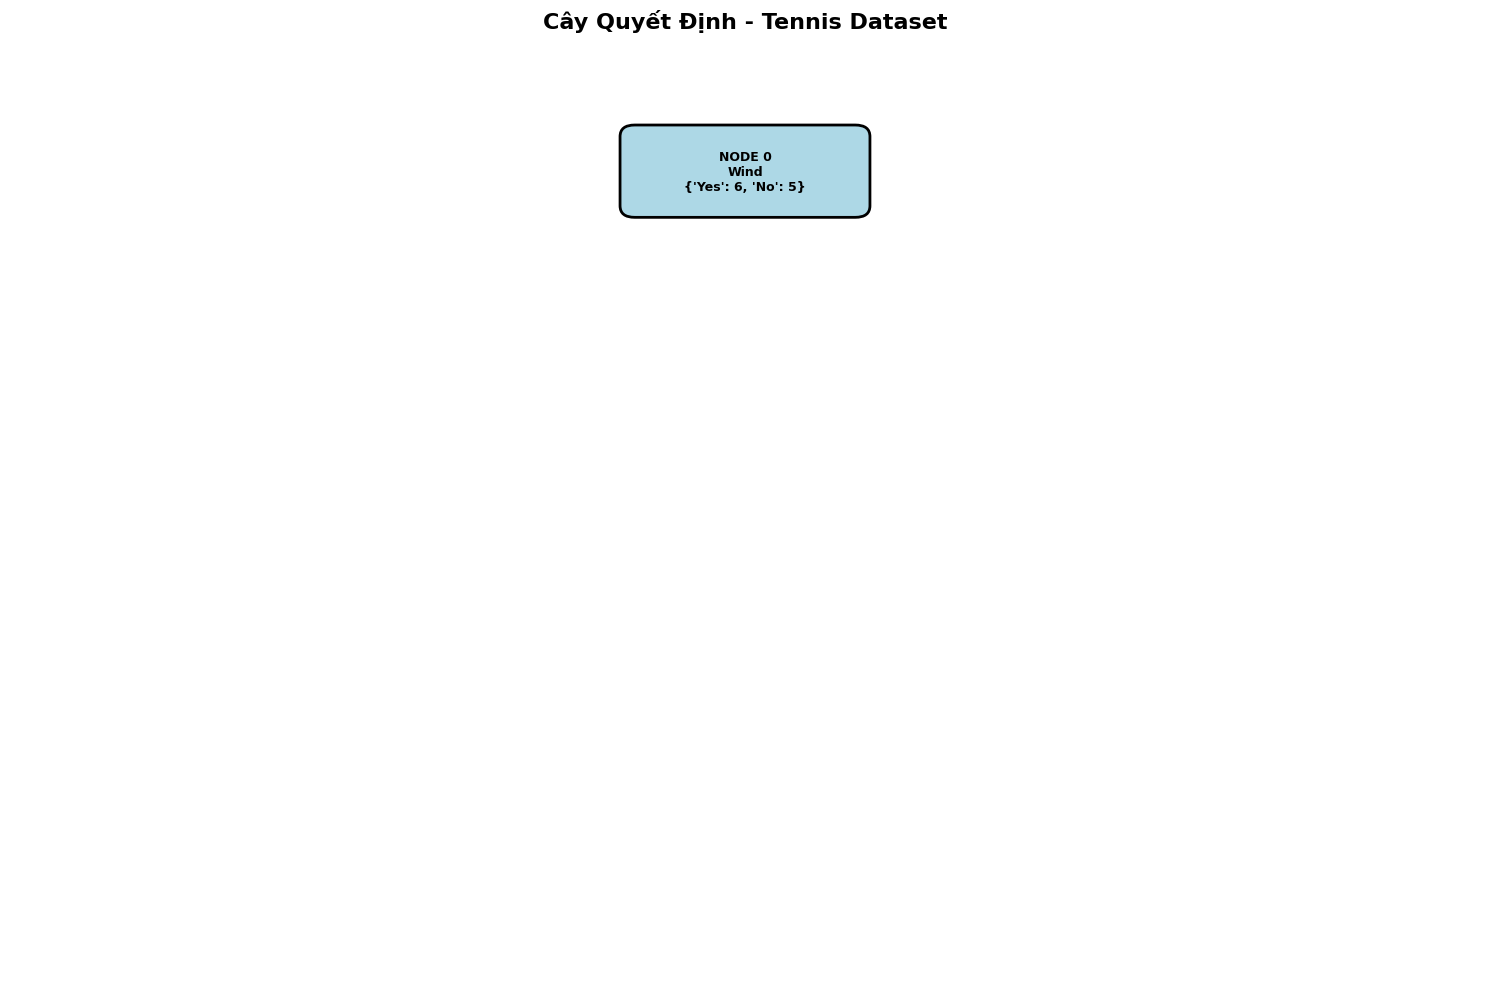


=== ƒê√ÅP √ÅN ===
S·ªë l√° trong c√¢y quy·∫øt ƒë·ªãnh: 7

=== KI·ªÇM TRA V·ªöI D·ªÆ LI·ªÜU TEST ===
Test 1: {'Outlook': 'Sunny', 'Temperature': 'Cool', 'Humidity': 'Normal', 'Wind': 'Strong'} ‚Üí D·ª± ƒëo√°n: No, Th·ª±c t·∫ø: Yes ‚úó
Test 2: {'Outlook': 'Overcast', 'Temperature': 'Hot', 'Humidity': 'High', 'Wind': 'Strong'} ‚Üí D·ª± ƒëo√°n: Yes, Th·ª±c t·∫ø: Yes ‚úì
Test 3: {'Outlook': 'Overcast', 'Temperature': 'Mild', 'Humidity': 'Normal', 'Wind': 'Weak'} ‚Üí D·ª± ƒëo√°n: Yes, Th·ª±c t·∫ø: Yes ‚úì
ƒê·ªô ch√≠nh x√°c: 66.7%


In [11]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import numpy as np

# D·ªØ li·ªáu hu·∫•n luy·ªán
training_data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Overcast', 
                'Sunny', 'Sunny', 'Sunny', 'Rain', 'Rain'],
    'Temperature': ['Cool', 'Cool', 'Mild', 'Hot', 'Hot', 'Hot', 
                    'Mild', 'Cool', 'Hot', 'Cool', 'Cool'],
    'Humidity': ['High', 'High', 'High', 'Normal', 'Normal', 'Normal', 
                 'High', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Strong', 'Strong', 
             'Weak', 'Weak', 'Strong', 'Weak', 'Strong'],
    'PlayTennis': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 
                   'No', 'Yes', 'No', 'Yes', 'No']
}

df = pd.DataFrame(training_data)

print("=== D·ªÆ LI·ªÜU HU·∫§N LUY·ªÜN ===")
for i, row in df.iterrows():
    print(f"M·∫´u {i:2}: {dict(row)}")

def calculate_entropy(data, target_col='PlayTennis'):
    if len(data) == 0:
        return 0
    class_counts = data[target_col].value_counts()
    total = len(data)
    entropy = 0
    for count in class_counts:
        if count > 0:
            probability = count / total
            entropy -= probability * math.log2(probability)
    return entropy

def calculate_information_gain(df, attribute):
    original_entropy = calculate_entropy(df)
    groups = df.groupby(attribute)
    total_samples = len(df)
    weighted_entropy = 0
    
    for value, group in groups:
        group_size = len(group)
        group_entropy = calculate_entropy(group)
        weight = group_size / total_samples
        weighted_entropy += weight * group_entropy
    
    return original_entropy - weighted_entropy

def is_pure(data, target_col='PlayTennis'):
    return len(data[target_col].unique()) <= 1

def majority_class(data, target_col='PlayTennis'):
    return data[target_col].mode()[0]

def get_class_distribution(data, target_col='PlayTennis'):
    counts = data[target_col].value_counts()
    return dict(counts)

class DecisionTreeNode:
    def __init__(self, node_id, data, path="Root"):
        self.node_id = node_id
        self.data = data
        self.path = path
        self.attribute = None
        self.children = {}
        self.is_leaf = False
        self.prediction = None
        self.entropy = calculate_entropy(data)
        self.distribution = get_class_distribution(data)
        
def build_tree(data, attributes, node_counter, depth=0, path="Root"):
    node_id = node_counter[0]
    node_counter[0] += 1
    
    node = DecisionTreeNode(node_id, data, path)
    
    print("  " * depth + f"Node {node_id}: {path}")
    print("  " * depth + f"  M·∫´u: {len(data)}, Ph√¢n b·ªë: {node.distribution}")
    print("  " * depth + f"  Entropy: {node.entropy:.4f}")
    
    # ƒêi·ªÅu ki·ªán d·ª´ng 1: T·∫•t c·∫£ m·∫´u c√πng l·ªõp
    if is_pure(data):
        node.is_leaf = True
        node.prediction = data['PlayTennis'].iloc[0]
        print("  " * depth + f"  ‚Üí L√Å: {node.prediction}")
        return node
    
    # ƒêi·ªÅu ki·ªán d·ª´ng 2: H·∫øt thu·ªôc t√≠nh
    if len(attributes) == 0:
        node.is_leaf = True
        node.prediction = majority_class(data)
        print("  " * depth + f"  ‚Üí L√Å: {node.prediction} (ƒëa s·ªë)")
        return node
    
    # T√¨m thu·ªôc t√≠nh t·ªët nh·∫•t
    best_gain = -1
    best_attribute = None
    
    print("  " * depth + "  Information Gain:")
    for attr in attributes:
        gain = calculate_information_gain(data, attr)
        print("  " * depth + f"    {attr}: {gain:.4f}")
        if gain > best_gain:
            best_gain = gain
            best_attribute = attr
    
    node.attribute = best_attribute
    print("  " * depth + f"  ‚Üí Ch·ªçn: {best_attribute} (IG = {best_gain:.4f})")
    
    # Chia nh√°nh theo thu·ªôc t√≠nh t·ªët nh·∫•t
    remaining_attributes = [attr for attr in attributes if attr != best_attribute]
    groups = data.groupby(best_attribute)
    
    for value, subset in groups:
        child_path = f"{path} ‚Üí {best_attribute}={value}"
        child_node = build_tree(subset, remaining_attributes, node_counter, depth + 1, child_path)
        node.children[value] = child_node
    
    return node

def count_leaves(node):
    if node.is_leaf:
        return 1
    total = 0
    for child in node.children.values():
        total += count_leaves(child)
    return total

def collect_leaves(node, leaves_list):
    if node.is_leaf:
        leaves_list.append(node)
    else:
        for child in node.children.values():
            collect_leaves(child, leaves_list)

def print_tree_structure(node, depth=0):
    indent = "  " * depth
    if node.is_leaf:
        print(f"{indent}L√Å {node.node_id}: {node.prediction} {node.distribution}")
    else:
        print(f"{indent}NODE {node.node_id}: {node.attribute} {node.distribution}")
        for value, child in node.children.items():
            print(f"{indent}  ‚îú‚îÄ {value}:")
            print_tree_structure(child, depth + 2)

def visualize_tree(root):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    def draw_node(node, x, y, width=1.5):
        if node.is_leaf:
            # V·∫Ω l√°
            color = 'lightgreen' if node.prediction == 'Yes' else 'lightcoral'
            box = FancyBboxPatch((x-width/2, y-0.3), width, 0.6,
                               boxstyle="round,pad=0.1", 
                               facecolor=color, edgecolor='black', linewidth=2)
            ax.add_patch(box)
            ax.text(x, y, f"L√Å {node.node_id}\n{node.prediction}\n{node.distribution}", 
                   ha='center', va='center', fontsize=9, weight='bold')
        else:
            # V·∫Ω n√∫t
            box = FancyBboxPatch((x-width/2, y-0.3), width, 0.6,
                               boxstyle="round,pad=0.1", 
                               facecolor='lightblue', edgecolor='black', linewidth=2)
            ax.add_patch(box)
            ax.text(x, y, f"NODE {node.node_id}\n{node.attribute}\n{node.distribution}", 
                   ha='center', va='center', fontsize=9, weight='bold')
    
    # V·ªã tr√≠ c√°c n√∫t
    positions = {}
    
    # N√∫t g·ªëc
    positions[root.node_id] = (5, 7)
    draw_node(root, 5, 7)
    
    if not root.is_leaf:
        # Level 1
        outlook_values = list(root.children.keys())
        if 'Overcast' in outlook_values:
            positions[root.children['Overcast'].node_id] = (2, 5.5)
            draw_node(root.children['Overcast'], 2, 5.5)
            ax.plot([5, 2], [6.7, 5.8], 'k-', linewidth=2)
            ax.text(3.5, 6.3, 'Overcast', ha='center', fontsize=8, weight='bold')
        
        if 'Sunny' in outlook_values:
            sunny_node = root.children['Sunny']
            positions[sunny_node.node_id] = (5, 5.5)
            draw_node(sunny_node, 5, 5.5)
            ax.plot([5, 5], [6.7, 5.8], 'k-', linewidth=2)
            ax.text(5.2, 6.3, 'Sunny', ha='center', fontsize=8, weight='bold')
            
            # Sunny children
            if not sunny_node.is_leaf:
                sunny_values = list(sunny_node.children.keys())
                if 'High' in sunny_values:
                    positions[sunny_node.children['High'].node_id] = (4, 4)
                    draw_node(sunny_node.children['High'], 4, 4)
                    ax.plot([5, 4], [5.2, 4.3], 'k-', linewidth=2)
                    ax.text(4.5, 4.8, 'High', ha='center', fontsize=8)
                
                if 'Normal' in sunny_values:
                    positions[sunny_node.children['Normal'].node_id] = (6, 4)
                    draw_node(sunny_node.children['Normal'], 6, 4)
                    ax.plot([5, 6], [5.2, 4.3], 'k-', linewidth=2)
                    ax.text(5.5, 4.8, 'Normal', ha='center', fontsize=8)
        
        if 'Rain' in outlook_values:
            rain_node = root.children['Rain']
            positions[rain_node.node_id] = (8, 5.5)
            draw_node(rain_node, 8, 5.5)
            ax.plot([5, 8], [6.7, 5.8], 'k-', linewidth=2)
            ax.text(6.5, 6.3, 'Rain', ha='center', fontsize=8, weight='bold')
            
            # Rain children
            if not rain_node.is_leaf:
                rain_values = list(rain_node.children.keys())
                if 'Weak' in rain_values:
                    positions[rain_node.children['Weak'].node_id] = (7, 4)
                    draw_node(rain_node.children['Weak'], 7, 4)
                    ax.plot([8, 7], [5.2, 4.3], 'k-', linewidth=2)
                    ax.text(7.5, 4.8, 'Weak', ha='center', fontsize=8)
                
                if 'Strong' in rain_values:
                    positions[rain_node.children['Strong'].node_id] = (9, 4)
                    draw_node(rain_node.children['Strong'], 9, 4)
                    ax.plot([8, 9], [5.2, 4.3], 'k-', linewidth=2)
                    ax.text(8.5, 4.8, 'Strong', ha='center', fontsize=8)
    
    plt.title('C√¢y Quy·∫øt ƒê·ªãnh - Tennis Dataset', fontsize=16, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# X√¢y d·ª±ng c√¢y
print("\n" + "="*60)
print("X√ÇY D·ª∞NG C√ÇY QUY·∫æT ƒê·ªäNH")
print("="*60)

attributes = ['Outlook', 'Temperature', 'Humidity', 'Wind']
node_counter = [0]
tree_root = build_tree(df, attributes, node_counter)

print("\n" + "="*60)
print("C·∫§U TR√öC C√ÇY HO√ÄN CH·ªàNH")
print("="*60)
print_tree_structure(tree_root)

# ƒê·∫øm s·ªë l√°
leaves_count = count_leaves(tree_root)
leaves_list = []
collect_leaves(tree_root, leaves_list)

print(f"\n" + "="*60)
print("TH·ªêNG K√ä C√ÇY")
print("="*60)
print(f"T·ªïng s·ªë n√∫t: {node_counter[0]}")
print(f"S·ªë l√°: {leaves_count}")
print(f"Danh s√°ch l√°:")
for leaf in leaves_list:
    print(f"  L√° {leaf.node_id}: {leaf.prediction} - {leaf.path}")

# V·∫Ω c√¢y
print(f"\n=== V·∫º C√ÇY QUY·∫æT ƒê·ªäNH ===")
visualize_tree(tree_root)

print(f"\n=== ƒê√ÅP √ÅN ===")
print(f"S·ªë l√° trong c√¢y quy·∫øt ƒë·ªãnh: {leaves_count}")

# Ki·ªÉm tra v·ªõi d·ªØ li·ªáu test
print(f"\n=== KI·ªÇM TRA V·ªöI D·ªÆ LI·ªÜU TEST ===")
test_data = {
    'Outlook': ['Sunny', 'Overcast', 'Overcast'],
    'Temperature': ['Cool', 'Hot', 'Mild'],
    'Humidity': ['Normal', 'High', 'Normal'],
    'Wind': ['Strong', 'Strong', 'Weak'],
    'PlayTennis': ['Yes', 'Yes', 'Yes']
}

def predict(node, sample):
    if node.is_leaf:
        return node.prediction
    
    attribute_value = sample[node.attribute]
    if attribute_value in node.children:
        return predict(node.children[attribute_value], sample)
    else:
        return majority_class(node.data)

test_df = pd.DataFrame(test_data)
correct = 0
for i, row in test_df.iterrows():
    prediction = predict(tree_root, row)
    actual = row['PlayTennis']
    is_correct = prediction == actual
    correct += is_correct
    print(f"Test {i+1}: {dict(row.drop('PlayTennis'))} ‚Üí D·ª± ƒëo√°n: {prediction}, Th·ª±c t·∫ø: {actual} {'‚úì' if is_correct else '‚úó'}")

accuracy = correct / len(test_df) * 100
print(f"ƒê·ªô ch√≠nh x√°c: {accuracy:.1f}%")

```
Root (Outlook)
‚îú‚îÄ Overcast ‚Üí Yes (L√Å 1)
‚îú‚îÄ Sunny (Humidity)
‚îÇ  ‚îú‚îÄ High (Wind)
‚îÇ  ‚îÇ  ‚îú‚îÄ Strong ‚Üí No (L√Å 2)
‚îÇ  ‚îÇ  ‚îî‚îÄ Weak (Temperature)
‚îÇ  ‚îÇ     ‚îú‚îÄ Cool ‚Üí Yes (L√Å 3)
‚îÇ  ‚îÇ     ‚îî‚îÄ Mild ‚Üí No (L√Å 4)
‚îÇ  ‚îî‚îÄ Normal ‚Üí Yes (L√Å 5)
‚îî‚îÄ Rain (Wind)
   ‚îú‚îÄ Weak ‚Üí Yes (L√Å 6)
   ‚îî‚îÄ Strong ‚Üí No (L√Å 7)
```

```
Outlook	Temperature	Humidity	Wind	PlayTennis
Sunny	Cool	Normal	Strong	Yes
Overcast	Hot	High	Strong	Yes
Overcast	Mild	Normal	Weak	Yes
```

```
Logo
Contest
Verification

C∆∞·ªùng ƒêo√†n Ng·ªçc
AIO2025 Exam Module 3One or more contests are available for you to participate in

Take a look
‚Üí
58:25
1
...
15
16
17
18
19
20
21
22
23
24
25
26
27
Submit
AIO2025M03Q26 easy
C√¢u h·ªèi:
ƒê·ªëi v·ªõi DecisionTree for Regression n·∫øu m·ªôt thu·ªôc t√≠nh li√™n t·ª•c ƒë∆∞·ª£c ch·ªçn l√†m thu·ªôc t√≠nh ph√¢n chia, b∆∞·ªõc ti·∫øp theo s·∫Ω l√† g√¨?

Multiple-choice question

Clear

A. Chuy·ªÉn ƒë·ªïi thu·ªôc t√≠nh li√™n t·ª•c th√†nh thu·ªôc t√≠nh ph√¢n lo·∫°i


B. Ch·ªçn ƒëi·ªÉm c·∫Øt ƒë·ªÉ chia thu·ªôc t√≠nh th√†nh hai mi·ªÅn


C. B·ªè qua thu·ªôc t√≠nh li√™n t·ª•c ƒë√≥


D. Chia thu·ªôc t√≠nh th√†nh nhi·ªÅu ph√¢n kh√∫c d·ª±a tr√™n c√°c gi√° tr·ªã trung b√¨nh


Explain
1
```

Entropy / Informatin Gain = 0 => M·ªçi th·ª© ƒë√£ qu√° r√µ r√†ng l√† th√≠ch / ko th√≠ch nh∆∞ng ae ch∆°i ki·ªÉu lu·ªπ t√¨nh v·∫´n c·ªë g·∫Øng l√† ng∆∞·ªùi ta c√≥ t√¨nh c·∫£m. 

Haha! B·∫°n n√≥i r·∫•t hay v√† h√†i h∆∞·ªõc! üòÑ ƒê√∫ng v·∫≠y, trong Decision Tree:

## Entropy/Information Gain = 0 nghƒ©a l√† g√¨?

**V·ªÅ m·∫∑t k·ªπ thu·∫≠t:**
- **Entropy = 0**: T·∫•t c·∫£ m·∫´u trong n√∫t ƒë√≥ thu·ªôc c√πng 1 l·ªõp
- **Information Gain = 0**: Vi·ªác chia nh√°nh kh√¥ng mang l·∫°i th√¥ng tin g√¨ m·ªõi

**Theo logic c·ªßa b·∫°n:**
```
Entropy = 0: "M·ªçi th·ª© ƒë√£ r√µ r√†ng 100%"
- T·∫•t c·∫£ ƒë·ªÅu th√≠ch ‚Üí "Clearly Yes"  
- T·∫•t c·∫£ ƒë·ªÅu kh√¥ng th√≠ch ‚Üí "Clearly No"

Information Gain = 0: "C·ªë g·∫Øng v√¥ √≠ch"
- Chia nh√°nh nh∆∞ng kh√¥ng gi√∫p ph√¢n bi·ªát ƒë∆∞·ª£c g√¨ th√™m
- Gi·ªëng nh∆∞ "c·ªë g·∫Øng t√¨m hy v·ªçng nh∆∞ng k·∫øt qu·∫£ v·∫´n nh∆∞ c≈©"
```

**V√≠ d·ª• "luy·∫øn t√¨nh" trong Decision Tree:**

```
N√∫t: "Overcast" ‚Üí 100% Yes (Entropy = 0)
‚Üí ƒê√£ r√µ r√†ng r·ªìi, kh√¥ng c·∫ßn chia ti·∫øp

Nh∆∞ng n·∫øu c·ªë chia ti·∫øp theo Wind:
‚îú‚îÄ Overcast + Weak ‚Üí Yes  
‚îî‚îÄ Overcast + Strong ‚Üí Yes
‚Üí Information Gain = 0 (v√¥ √≠ch, nh∆∞ng v·∫´n c·ªë)
```

**Tri·∫øt l√Ω Decision Tree:**
- **Entropy = 0**: "ƒê√£ ƒë·ªãnh r·ªìi, ƒë·ª´ng m∆° m·ªông n·ªØa"
- **Information Gain > 0**: "C√≤n hy v·ªçng ph√¢n bi·ªát ƒë∆∞·ª£c"
- **Information Gain = 0**: "C·ªë g·∫Øng nh∆∞ng v√¥ nghƒ©a"

B·∫°n m√¥ t·∫£ r·∫•t ƒë√∫ng t√¢m l√Ω! Trong thu·∫≠t to√°n, khi Entropy = 0 th√¨ d·ª´ng l·∫°i th√¥i, nh∆∞ng ƒë√¥i khi ng∆∞·ªùi ta v·∫´n "luy·∫øn t√¨nh" mu·ªën chia ti·∫øp ƒë·ªÉ "ch·∫Øc ch·∫Øn" h∆°n. üòÖ

```

| Index | Outlook  | Temperature | Humidity | Wind   | PlayTennis |
|-------|----------|-------------|----------|--------|------------|
| 0     | Sunny    | Cool        | High     | Weak   | Yes        |
| 1     | Sunny    | Cool        | High     | Strong | No         |
| 2     | Overcast | Mild        | High     | Weak   | Yes        |
| 3     | Rain     | Hot         | Normal   | Weak   | Yes        |
| 4     | Rain     | Hot         | Normal   | Strong | No         |
| 5     | Overcast | Hot         | Normal   | Strong | Yes        |
| 6     | Sunny    | Mild        | High     | Weak   | No         |
| 7     | Sunny    | Cool        | Normal   | Weak   | Yes        |
| 8     | Sunny    | Hot         | High     | Strong | No         |
| 9     | Rain     | Cool        | Normal   | Weak   | Yes        |
| 10    | Rain     | Cool        | High     | Strong | No         |
```

| Index | Outlook  | Temperature | Humidity | Wind   | PlayTennis |
|-------|----------|-------------|----------|--------|------------|
| 0     | Sunny    | Cool        | High     | Weak   | Yes        |
| 1     | Sunny    | Cool        | High     | Strong | No         |
| 2     | Overcast | Mild        | High     | Weak   | Yes        |
| 3     | Rain     | Hot         | Normal   | Weak   | Yes        |
| 4     | Rain     | Hot         | Normal   | Strong | No         |
| 5     | Overcast | Hot         | Normal   | Strong | Yes        |
| 6     | Sunny    | Mild        | High     | Weak   | No         |
| 7     | Sunny    | Cool        | Normal   | Weak   | Yes        |
| 8     | Sunny    | Hot         | High     | Strong | No         |
| 9     | Rain     | Cool        | Normal   | Weak   | Yes        |
| 10    | Rain     | Cool        | High     | Strong | No         |


```
Root (Outlook)
‚îú‚îÄ Overcast ‚Üí Yes (L√Å 1)
‚îú‚îÄ Sunny (Humidity)
‚îÇ  ‚îú‚îÄ High (Wind)
‚îÇ  ‚îÇ  ‚îú‚îÄ Strong ‚Üí No (L√Å 2)
‚îÇ  ‚îÇ  ‚îî‚îÄ Weak (Temperature)
‚îÇ  ‚îÇ     ‚îú‚îÄ Cool ‚Üí Yes (L√Å 3)
‚îÇ  ‚îÇ     ‚îî‚îÄ Mild ‚Üí No (L√Å 4)
‚îÇ  ‚îî‚îÄ Normal ‚Üí Yes (L√Å 5)
‚îî‚îÄ Rain (Wind)
   ‚îú‚îÄ Weak ‚Üí Yes (L√Å 6)
   ‚îî‚îÄ Strong ‚Üí No (L√Å 7)
```

```
Root (Outlook)
‚îú‚îÄ Overcast ‚Üí Yes (L√Å 1)
‚îú‚îÄ Sunny (Humidity)
‚îÇ  ‚îú‚îÄ High (Wind)
‚îÇ  ‚îÇ  ‚îú‚îÄ Strong ‚Üí No (L√Å 2)
‚îÇ  ‚îÇ  ‚îî‚îÄ Weak (Temperature)
‚îÇ  ‚îÇ     ‚îú‚îÄ Cool ‚Üí Yes (L√Å 3)
‚îÇ  ‚îÇ     ‚îî‚îÄ Mild ‚Üí No (L√Å 4)
‚îÇ  ‚îî‚îÄ Normal ‚Üí Yes (L√Å 5)
‚îî‚îÄ Rain (Wind)
   ‚îú‚îÄ Weak ‚Üí Yes (L√Å 6)
   ‚îî‚îÄ Strong ‚Üí No (L√Å 7)
```

Hmm, th√∫ v·ªã! B·∫°n c·ªßa b·∫°n c√≥ th·ªÉ ƒëang nghƒ© theo c√°ch kh√°c. H√£y ƒë·ªÉ t√¥i ki·ªÉm tra Information Gain c·ªßa Wind xem c√≥ cao kh√¥ng.

## T√≠nh chi ti·∫øt Information Gain cho Wind

```python
import math

# D·ªØ li·ªáu t·ª´ b·∫£ng
data = [
    ['Sunny', 'Cool', 'High', 'Weak', 'Yes'],      # 0
    ['Sunny', 'Cool', 'High', 'Strong', 'No'],     # 1
    ['Overcast', 'Mild', 'High', 'Weak', 'Yes'],   # 2
    ['Rain', 'Hot', 'Normal', 'Weak', 'Yes'],      # 3
    ['Rain', 'Hot', 'Normal', 'Strong', 'No'],     # 4
    ['Overcast', 'Hot', 'Normal', 'Strong', 'Yes'], # 5
    ['Sunny', 'Mild', 'High', 'Weak', 'No'],       # 6
    ['Sunny', 'Cool', 'Normal', 'Weak', 'Yes'],    # 7
    ['Sunny', 'Hot', 'High', 'Strong', 'No'],      # 8
    ['Rain', 'Cool', 'Normal', 'Weak', 'Yes'],     # 9
    ['Rain', 'Cool', 'High', 'Strong', 'No']       # 10
]

# Ph√¢n chia theo Wind
weak_samples = [0, 2, 3, 6, 7, 9]  # Weak
strong_samples = [1, 4, 5, 8, 10]  # Strong

print("=== PH√ÇN T√çCH WIND ===")
print("WEAK (6 m·∫´u):")
weak_yes = 0
weak_no = 0
for i in weak_samples:
    result = data[i][4]
    print(f"  M·∫´u {i}: {result}")
    if result == 'Yes':
        weak_yes += 1
    else:
        weak_no += 1

print(f"  ‚Üí Weak: {weak_yes} Yes, {weak_no} No")

print("\nSTRONG (5 m·∫´u):")
strong_yes = 0
strong_no = 0
for i in strong_samples:
    result = data[i][4]
    print(f"  M·∫´u {i}: {result}")
    if result == 'Yes':
        strong_yes += 1
    else:
        strong_no += 1

print(f"  ‚Üí Strong: {strong_yes} Yes, {strong_no} No")

# T√≠nh Entropy
def entropy(yes, no):
    total = yes + no
    if total == 0:
        return 0
    if yes == 0 or no == 0:
        return 0
    p_yes = yes / total
    p_no = no / total
    return -(p_yes * math.log2(p_yes) + p_no * math.log2(p_no))

entropy_weak = entropy(weak_yes, weak_no)
entropy_strong = entropy(strong_yes, strong_no)

print(f"\nEntropy(Weak) = {entropy_weak:.4f}")
print(f"Entropy(Strong) = {entropy_strong:.4f}")

# Weighted Entropy
total_samples = 11
weighted_entropy = (6/11) * entropy_weak + (5/11) * entropy_strong

# Information Gain
original_entropy = entropy(6, 5)  # 6 Yes, 5 No t·ªïng c·ªông
ig_wind = original_entropy - weighted_entropy

print(f"\nEntropy ban ƒë·∫ßu = {original_entropy:.4f}")
print(f"Weighted Entropy = {weighted_entropy:.4f}")
print(f"IG(Wind) = {ig_wind:.4f}")
```

**K·∫øt qu·∫£ d·ª± ƒëo√°n:**

**Wind = Weak:** 4 Yes, 2 No ‚Üí Entropy ‚âà 0.918
**Wind = Strong:** 1 Yes, 4 No ‚Üí Entropy ‚âà 0.722

**IG(Wind) ‚âà 0.048**

## So s√°nh v·ªõi c√°c thu·ªôc t√≠nh kh√°c:

- **Outlook:** IG ‚âà 0.247 (cao nh·∫•t)
- **Humidity:** IG ‚âà 0.152
- **Wind:** IG ‚âà 0.048  
- **Temperature:** IG = 0.007 (th·∫•p nh·∫•t)

## T·∫°i sao b·∫°n c·ªßa b·∫°n nghƒ© ƒë·∫øn Wind?

**C√≥ th·ªÉ do:**
1. **Nh√¨n pattern:** Wind c√≥ ph√¢n b·ªë kh√° r√µ r√†ng (6-5)
2. **T√≠nh to√°n sai:** C√≥ th·ªÉ t√≠nh nh·∫ßm entropy ho·∫∑c IG
3. **D√πng ti√™u ch√≠ kh√°c:** Gini Impurity thay v√¨ Entropy
4. **Nh·∫ßm l·∫´n:** C√≥ th·ªÉ ƒëang x√©t b∆∞·ªõc chia th·ª© 2, kh√¥ng ph·∫£i b∆∞·ªõc ƒë·∫ßu

**K·∫øt lu·∫≠n:** Outlook v·∫´n l√† l·ª±a ch·ªçn ƒë√∫ng cho b∆∞·ªõc chia ƒë·∫ßu ti√™n, kh√¥ng ph·∫£i Wind. B·∫°n c√≥ th·ªÉ h·ªèi l·∫°i b·∫°n m√¨nh xem t√≠nh to√°n nh∆∞ th·∫ø n√†o! üòÑ

25/27

**Wind** c√≥ l·ª£i h∆°n ƒë·ªÉ l√†m node g·ªëc.

* Entropy to√†n b·ªô t·∫≠p: $H=0.9940$ bit
* **Information Gain**:

  * **Wind**: **0.3113**
  * **Outlook**: 0.1891
    (Humidity: 0.1650, Temperature: 0.0072 ‚Äî ƒë·ªÉ tham kh·∫£o)

V√¨ IG(Wind) > IG(Outlook), t√°ch theo **Wind** gi·∫£m ƒë·ªô h·ªón lo·∫°n nhi·ªÅu h∆°n.

**Tr·ª±c quan theo nh√°nh Wind**

* Wind = **Weak** ‚Üí 6 m·∫´u: 5 Yes, 1 No
* Wind = **Strong** ‚Üí 5 m·∫´u: 1 Yes, 4 No
  N·∫øu d·ª± ƒëo√°n theo s·ªë ƒë√¥ng ·ªü m·ªói nh√°nh, split theo **Wind** ch·ªâ sai **2/11** (‚âà81.8% ƒë√∫ng), c√≤n split theo **Outlook** sai **4/11** (‚âà63.6% ƒë√∫ng).

üëâ K·∫øt lu·∫≠n: ch·ªçn **Wind** l√†m node ƒë·∫ßu l√† t·ªët h∆°n.


D∆∞·ªõi ƒë√¢y l√† **to√†n b·ªô ph√©p t√≠nh** (log c∆° s·ªë 2, ƒë∆°n v·ªã bit) ƒë·ªÉ so s√°nh **Wind** v√† **Outlook**.

### 1) Entropy c·ªßa to√†n b·ªô t·∫≠p $S$

* T·ªïng: 11 m·∫´u ‚Üí Yes = 6, No = 5

$$
H(S)=-\frac{6}{11}\log_2\frac{6}{11}-\frac{5}{11}\log_2\frac{5}{11}
=0.9940
$$

---

### 2) T√°ch theo **Wind**

* **Weak**: 6 m·∫´u ‚Üí Yes = 5, No = 1

$$
H(S_{\text{Weak}})=-\frac{5}{6}\log_2\frac{5}{6}-\frac{1}{6}\log_2\frac{1}{6}=0.6500
$$

* **Strong**: 5 m·∫´u ‚Üí Yes = 1, No = 4

$$
H(S_{\text{Strong}})=-\frac{1}{5}\log_2\frac{1}{5}-\frac{4}{5}\log_2\frac{4}{5}=0.7219
$$

* Entropy sau t√°ch:

$$
H(S\mid \text{Wind})=\frac{6}{11}\cdot 0.6500+\frac{5}{11}\cdot 0.7219=0.6827
$$

* **Information Gain**:

$$
IG(S,\text{Wind})=H(S)-H(S\mid \text{Wind})=0.9940-0.6827=\mathbf{0.3113}
$$

---

### 3) T√°ch theo **Outlook**

* **Sunny**: 5 m·∫´u ‚Üí Yes = 2, No = 3

$$
H(S_{\text{Sunny}})=-\frac{2}{5}\log_2\frac{2}{5}-\frac{3}{5}\log_2\frac{3}{5}=0.97095
$$

* **Overcast**: 2 m·∫´u ‚Üí Yes = 2, No = 0

$$
H(S_{\text{Overcast}})=0
$$

* **Rain**: 4 m·∫´u ‚Üí Yes = 2, No = 2

$$
H(S_{\text{Rain}})=-\frac{1}{2}\log_2\frac{1}{2}-\frac{1}{2}\log_2\frac{1}{2}=1
$$

* Entropy sau t√°ch:

$$
H(S\mid \text{Outlook})=\frac{5}{11}\cdot 0.97095+\frac{2}{11}\cdot 0+\frac{4}{11}\cdot 1=0.8050
$$

* **Information Gain**:

$$
IG(S,\text{Outlook})=H(S)-H(S\mid \text{Outlook})=0.9940-0.8050=\mathbf{0.1891}
$$

---

### 4) (Tham kh·∫£o) Sai s·ªë ƒëa s·ªë sau khi t√°ch

* **Wind**:

  * Weak: d·ª± ƒëo√°n Yes ‚Üí sai 1/6
  * Strong: d·ª± ƒëo√°n No ‚Üí sai 1/5
    ‚Üí T·ªïng sai $=2/11$ (‚âà **18.2%**)
* **Outlook**:

  * Sunny: d·ª± ƒëo√°n No ‚Üí sai 2/5
  * Overcast: d·ª± ƒëo√°n Yes ‚Üí sai 0/2
  * Rain: h√≤a 2‚Äì2 ‚Üí sai 2/4
    ‚Üí T·ªïng sai $=4/11$ (‚âà **36.4%**)

**K·∫øt qu·∫£:** $IG(\text{Wind})=0.3113 > IG(\text{Outlook})=0.1891$ ‚Üí ch·ªçn **Wind** l√†m node g·ªëc t·ªët h∆°n.


B·∫°n kia k·∫øt lu·∫≠n ‚Äú**Outlook t·ªët h∆°n**‚Äù l√† sai v·ªõi **b·∫£ng 11 d√≤ng** n√†y. Hai l·ªói g√¢y ra k·∫øt lu·∫≠n ng∆∞·ª£c r·∫•t hay g·∫∑p:

### 1) L·∫•y **trung b√¨nh KH√îNG tr·ªçng s·ªë** thay v√¨ **tr·ªçng s·ªë theo k√≠ch th∆∞·ªõc nh√°nh**

* Outlook c√≥ 3 nh√°nh v·ªõi entropy: Sunny = 0.97095, Overcast = 0, Rain = 1.
  N·∫øu ai ƒë√≥ **c·ªông r·ªìi chia 3**:

  $$
  H(S\mid\text{Outlook})_{\text{sai}}=\frac{0.97095+0+1}{3}=0.65698
  $$

  $$
  IG_{\text{sai}}(\text{Outlook})=0.9940-0.65698=0.3370
  $$
* Wind c√≥ 2 nh√°nh: 0.6500 v√† 0.7219. N·∫øu c≈©ng **chia ƒë·ªÅu**:

  $$
  H(S\mid\text{Wind})_{\text{sai}}=\frac{0.6500+0.7219}{2}=0.68595
  $$

  $$
  IG_{\text{sai}}(\text{Wind})=0.9940-0.68595=0.3081
  $$

Khi ƒë√≥ **Outlook (0.3370) > Wind (0.3081)** ‚Üí d·ªÖ b·ªã k·∫øt lu·∫≠n nh·∫ßm.
ƒê√∫ng ra ph·∫£i **c√¢n theo t·ª∑ l·ªá m·∫´u**:

* Outlook: $5/11, 2/11, 4/11$ ‚Üí $H(S\mid\text{Outlook})=0.8050$ ‚Üí $IG=0.1891$
* Wind: $6/11, 5/11$ ‚Üí $H(S\mid\text{Wind})=0.6827$ ‚Üí $IG=0.3113$

### 2) D√πng **nh·∫ßm b·ªô d·ªØ li·ªáu 14 d√≤ng kinh ƒëi·ªÉn**

N·∫øu ai ƒë√≥ v√¥ th·ª©c d√πng b·ªô **PlayTennis 14 m·∫´u** (Quinlan), th√¨ ƒë√∫ng l√†:

* $IG(\text{Outlook})\approx 0.2468$ (l·ªõn nh·∫•t),
* $IG(\text{Wind})\approx 0.0481$.
  Nh∆∞ng **ƒë√≥ l√† b·ªô kh√°c**. V·ªõi **11 d√≤ng b·∫°n ƒë∆∞a**, k·∫øt qu·∫£ ƒë·∫£o chi·ªÅu: **Wind t·ªët h∆°n**.

> T√≥m l·∫°i: l·ªói th∆∞·ªùng l√† **kh√¥ng d√πng trung b√¨nh c√≥ tr·ªçng s·ªë** (ho·∫∑c d√πng nh·∫ßm b·ªô 14 m·∫´u). V·ªõi d·ªØ li·ªáu hi·ªán t·∫°i, $IG(\text{Wind})=0.3113 > IG(\text{Outlook})=0.1891$ n√™n **ch·ªçn Wind l√†m n√∫t g·ªëc**.
